# Titanic - Machine Learning from Disaster

Легендарное ML-соревнование с [Kaggle](https://www.kaggle.com/c/titanic)

<img src='./Titanic.jpg' width=500>

Возможно, гибель Титаника - одно из самых печально известных кораблекрушений в истории. Титаник был крупнейшим действующим океанским лайнером своего времени, у него были улучшенные меры обеспечения безопасности, такие как водонепроницаемые отсеки и водонепроницаемые двери с дистанционным управлением. Корабль считался «непотопляемым», однако он затонул рано утром 15 апреля 1912 года в северной части Атлантического океана во время своего первого рейса из Саутгемптона в Нью-Йорк. В момент столкновения корабля с айсбергом на борту находились 2224 человека.

В соответствии с существующей в то время практикой система спасательных шлюпок Титаника была разработана для переправки пассажиров на ближайшие спасательные суда, а не для одновременного удержания всех на плаву. Таким образом, когда корабль быстро тонул (корабль затонул за 2 часа 40 минут), а до прибытия помощи оставалось еще несколько часов, многим пассажирам и членам экипажа не хватило места на спасательных шлюпках, которых было всего 20. Плохая организация эвакуации привела к тому, что многие лодки были спущены на воду до того, как были полностью заполнены.

В результате кораблекрушения погибло более 1500 человек, что сделало его одним из самых смертоносных в истории.

Без сомнения, при спасении пассажиров имел место элемент удачи, но, возможно, были те, кто имели большие шансы уцелеть чем другие. [Titanic ML competition on Kaggle](https://www.kaggle.com/c/titanic) предлагает участникам предсказать кто их пассажиров пережил кораблекрушение, основываясь на сохранившихся данных о пассажирах.

В Интернете можно найти десятки статей, посвященных этому соревнованию, и сотни решений этой задачи. В исследовательском анализе я во многом ориентировался на [эту статью](https://habr.com/ru/company/mlclass/blog/270973/) и позаимствовал из неё несколько идей.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-модулей-и-константы" data-toc-modified-id="Импорт-модулей-и-константы-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт модулей и константы</a></span></li><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Примечания-к-признкакм" data-toc-modified-id="Примечания-к-признкакм-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Примечания к признкакм</a></span></li><li><span><a href="#Пути-к-файлам" data-toc-modified-id="Пути-к-файлам-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Пути к файлам</a></span></li><li><span><a href="#Предположения" data-toc-modified-id="Предположения-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Предположения</a></span></li><li><span><a href="#Анализ-таблицы-с-результатами-соревнований" data-toc-modified-id="Анализ-таблицы-с-результатами-соревнований-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Анализ таблицы с результатами соревнований</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Знакомство-с-данными" data-toc-modified-id="Знакомство-с-данными-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Знакомство с данными</a></span></li><li><span><a href="#Разделения-на-тестовый-и-тренировочный-наборы" data-toc-modified-id="Разделения-на-тестовый-и-тренировочный-наборы-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Разделения на тестовый и тренировочный наборы</a></span></li><li><span><a href="#Исследовательский-анализ" data-toc-modified-id="Исследовательский-анализ-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Исследовательский анализ</a></span><ul class="toc-item"><li><span><a href="#Предварительный-анализ" data-toc-modified-id="Предварительный-анализ-11.1"><span class="toc-item-num">11.1&nbsp;&nbsp;</span>Предварительный анализ</a></span></li><li><span><a href="#Детальный-анализ-признаков" data-toc-modified-id="Детальный-анализ-признаков-11.2"><span class="toc-item-num">11.2&nbsp;&nbsp;</span>Детальный анализ признаков</a></span><ul class="toc-item"><li><span><a href="#Pclass" data-toc-modified-id="Pclass-11.2.1"><span class="toc-item-num">11.2.1&nbsp;&nbsp;</span>Pclass</a></span></li><li><span><a href="#Name" data-toc-modified-id="Name-11.2.2"><span class="toc-item-num">11.2.2&nbsp;&nbsp;</span>Name</a></span></li><li><span><a href="#Sex" data-toc-modified-id="Sex-11.2.3"><span class="toc-item-num">11.2.3&nbsp;&nbsp;</span>Sex</a></span></li><li><span><a href="#Age" data-toc-modified-id="Age-11.2.4"><span class="toc-item-num">11.2.4&nbsp;&nbsp;</span>Age</a></span></li><li><span><a href="#SibSp" data-toc-modified-id="SibSp-11.2.5"><span class="toc-item-num">11.2.5&nbsp;&nbsp;</span>SibSp</a></span></li><li><span><a href="#Parch" data-toc-modified-id="Parch-11.2.6"><span class="toc-item-num">11.2.6&nbsp;&nbsp;</span>Parch</a></span></li><li><span><a href="#Fare" data-toc-modified-id="Fare-11.2.7"><span class="toc-item-num">11.2.7&nbsp;&nbsp;</span>Fare</a></span></li><li><span><a href="#Cabin" data-toc-modified-id="Cabin-11.2.8"><span class="toc-item-num">11.2.8&nbsp;&nbsp;</span>Cabin</a></span></li><li><span><a href="#Embarked" data-toc-modified-id="Embarked-11.2.9"><span class="toc-item-num">11.2.9&nbsp;&nbsp;</span>Embarked</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-11.3"><span class="toc-item-num">11.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обработка-данных" data-toc-modified-id="Обработка-данных-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Обработка данных</a></span><ul class="toc-item"><li><span><a href="#Разработка-новых-признаков" data-toc-modified-id="Разработка-новых-признаков-12.1"><span class="toc-item-num">12.1&nbsp;&nbsp;</span>Разработка новых признаков</a></span><ul class="toc-item"><li><span><a href="#Title" data-toc-modified-id="Title-12.1.1"><span class="toc-item-num">12.1.1&nbsp;&nbsp;</span><code>Title</code></a></span></li><li><span><a href="#AgeGroup-и-FareGroup" data-toc-modified-id="AgeGroup-и-FareGroup-12.1.2"><span class="toc-item-num">12.1.2&nbsp;&nbsp;</span><code>AgeGroup</code> и <code>FareGroup</code></a></span></li><li><span><a href="#Family" data-toc-modified-id="Family-12.1.3"><span class="toc-item-num">12.1.3&nbsp;&nbsp;</span><code>Family</code></a></span></li><li><span><a href="#isFramily-и-isCabin" data-toc-modified-id="isFramily-и-isCabin-12.1.4"><span class="toc-item-num">12.1.4&nbsp;&nbsp;</span><code>isFramily</code> и <code>isCabin</code></a></span></li></ul></li><li><span><a href="#Оценка-информативности-признаков" data-toc-modified-id="Оценка-информативности-признаков-12.2"><span class="toc-item-num">12.2&nbsp;&nbsp;</span>Оценка информативности признаков</a></span><ul class="toc-item"><li><span><a href="#Конвейер" data-toc-modified-id="Конвейер-12.2.1"><span class="toc-item-num">12.2.1&nbsp;&nbsp;</span>Конвейер</a></span></li><li><span><a href="#Корреляция-между-обучающими-признаками" data-toc-modified-id="Корреляция-между-обучающими-признаками-12.2.2"><span class="toc-item-num">12.2.2&nbsp;&nbsp;</span>Корреляция между обучающими признаками</a></span></li><li><span><a href="#Взаимная-информация-(Mutual-Information)" data-toc-modified-id="Взаимная-информация-(Mutual-Information)-12.2.3"><span class="toc-item-num">12.2.3&nbsp;&nbsp;</span>Взаимная информация (Mutual Information)</a></span></li></ul></li></ul></li><li><span><a href="#Базовая-модель" data-toc-modified-id="Базовая-модель-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Базовая модель</a></span></li><li><span><a href="#Выбор-модели" data-toc-modified-id="Выбор-модели-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Выбор модели</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Отбор-признаков" data-toc-modified-id="Отбор-признаков-14.0.1"><span class="toc-item-num">14.0.1&nbsp;&nbsp;</span>Отбор признаков</a></span></li></ul></li></ul></li></ul></div>

## Импорт модулей и константы

In [1]:
import warnings


from category_encoders.target_encoder import TargetEncoder

from imblearn.over_sampling import SMOTE

from imblearn.pipeline import Pipeline

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from pandas.plotting import scatter_matrix

import seaborn as sns

from scipy.stats import (percentileofscore,
                         randint,
                         ttest_ind,
                         uniform,
                        )

from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA

from sklearn.dummy import DummyClassifier

from sklearn.ensemble import (GradientBoostingClassifier, 
                              RandomForestClassifier)

from sklearn.feature_selection import (mutual_info_classif, 
                                       RFECV)

from sklearn.impute import (MissingIndicator, 
                            SimpleImputer)

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve

from sklearn.model_selection import (cross_val_predict, 
                                     cross_val_score,
                                     train_test_split)

from sklearn.preprocessing import (Binarizer, 
                                   FunctionTransformer, 
                                   KBinsDiscretizer, 
                                   StandardScaler)

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier


warnings.simplefilter(action='ignore', category=FutureWarning)


SEED = 42


%matplotlib inline

## Описание проекта

**Цель** - предсказать выживет пассажир Тинтаника в кораблекрушении или нет.

**Тип задачи** - классификация (бинарная классификация).

**Целевая метрика** - *accuracy* (точность).

**Желаемое значение целевой метрики:** Табилца с результатами соревнований содержит почти 14000 записей. 
Медианное значение точности 0.775, но менее 4% имеют резутат выше 0.8. 
Таким образом, **значение метрики accuracy больше или равное 0.8 будет отличным результатом**.

**Существующие решения:** имеется огромное количество решений опубликованных в интернете и [на форуме](https://www.kaggle.com/c/titanic/discussion)

## Описание данных
0. **PassengerId** - ID пассажира.
1. **Survived** - Выживший:
    - 0 = Нет, 
    - 1 = Да.
2. **Pclass** - Класс билета:
    - 1 = первый, 
    - 2 = второй, 
    - 3 = третий.
3. **Name** - Имя пассажира, например Braund, Mr. Owen Harris.
4. **Sex** - Пол:
    - male - мужчина,
    - female - женщина.
5. **Age** - Возраст в годах, например 38.0.
6. **SibSp** - Количество братьев и сестер или супругов на борту Титаника.
7. **Parch** - Количество родителей или детей на борту Титаника.
8. **Ticket** - Номер билета, например A/5 21171.
9. **Fare** - Стоимость билета, например 71.2833.
10. **Cabin** - Номер каюты, напрмер C85.
11. **Embarked** - Порт, где пассажир сел на корабль:
    - C = Cherbourg,
    - Q = Queenstown,
    - S = Southampton.
    
**Признаки:** PassengerId, Pclass, Name, Sex, Age, SibSp, Parch, Ticket,
Fare, Cabin, Embarked

**Целевой признак** - Survived
    
## Примечания к признкакм
- **pclass**: социально-экономический статус
    - *1st* = Upper
    - *2nd* = Middle
    - *3rd* = Lower
- **age**: Возраст представлен дробным значением, если он меньше 1 года. Если возрас известен, то значение имеет вид xx.5.
- **sibsp**: Количество братьев и сестер или супругов на борту Титаника
    - *sibling* = брат, сестра, сводный брат, сводная сестра
    - *spouse* = муж, жена (любовницы, женихи и невесты игнорировались)
- **parch**: количество родителей (мать, отец)/детей (дочь, сын, в т.ч. приёмные) на борту Титаника. Некоторые дети путешествовали только с няней, поэтому для них parch=0.

## Пути к файлам
- **training set**: ../datasets/train.csv - набор данных для обучения модели.
- **test set**: ../datasets/test.csv - набор для подготовки предсказания для отправки на проверку.
- **example of a submission file**: ../datasets/gender_submission.csv - пример данных, подготовленных для проверки. В нём значения целевой переменной расставлены случайным образом.

## Предположения
У женщин было больше шансов выжить, чем у мужчин.

## Анализ таблицы с результатами соревнований
Скачаем [таблицу с результатами соревнования](https://www.kaggle.com/competitions/titanic/leaderboard) и проанализируем результаты в ней. Таблица загружена 07.01.2023.

Выведем первые 5 строк таблицы.

In [2]:
leaderboard = pd.read_csv('../datasets/titanic-publicleaderboard.csv')
leaderboard.head()

,TeamId,TeamName,SubmissionDate,Score
0,6987444,no name,2022-11-29 19:21:00,1.0
1,9431126,GloriaWin,2022-11-09 03:47:31,1.0
2,9433446,Ouyang Hao,2022-11-09 12:25:50,1.0
3,7943932,Aleksei Fomin,2022-12-07 08:36:15,1.0
4,9157107,Chaceli,2022-11-13 11:47:50,1.0


Неожиданно, в начале таблицы оказались результаты с точностью (метрика accuracy) равной 1. Неужели авторы смогли достичь совершенства?

Посчитаем описательные статистики для результатов приведённых в таблице (столбец `Score`).

In [3]:
leaderboard.Score.describe()

count    13702.000000
mean         0.758821
std          0.083441
min          0.000000
25%          0.765550
50%          0.775110
75%          0.777510
max          1.000000
Name: Score, dtype: float64

Посчитаем процент участников показавших результат лучше 0.8.

In [4]:
print(f'Только {1 - percentileofscore(leaderboard.Score, 0.8) / 100 :.2%} участников показали результат лучше 0.8')

Только 3.74% участников показали результат лучше 0.8


Таким образом, **значение метрики accuracy больше или равное 0.8 будет отличным результатом**.

Построим функцию распределения (ECDF) вероятности результатов участников. Красным отметим желаемое значение целевой метрики.

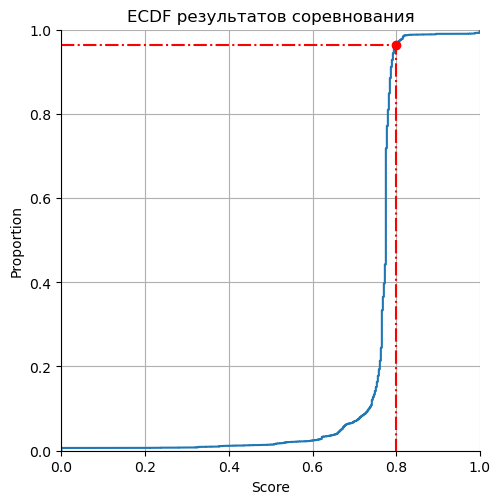

In [5]:
def plot_ecdf_with_target(data, target):
    sns.displot(data, stat='proportion', kind='ecdf', height=5, aspect=1)
    
    quantile = percentileofscore(data, target) / 100
    
    plt.plot([0, target, target], [quantile, quantile, 0], '-.r')
    plt.plot([target], [quantile], 'or')
    
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    
    plt.title('ECDF результатов соревнования')
    
    plt.grid()
    
    plt.show()

    
plot_ecdf_with_target(leaderboard.Score, 0.8)

Построим плотность распределения вероятности получения определённого результата соревнования. Красной стрелкой отметим результаты равные 1.0 .

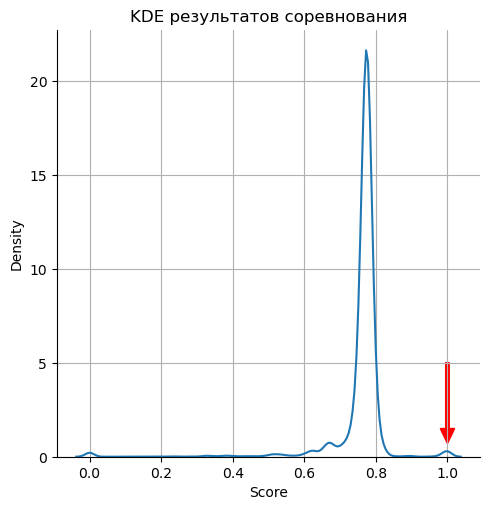

In [6]:
sns.displot(leaderboard, x='Score', kind='kde')

plt.arrow(x=1.0, y=5, dx=0, dy=-3.5, width=0.01, head_width=0.04, head_length=0.8, color='r')
plt.title("KDE результатов соревнования")
plt.grid()

plt.show()

Возможно, решения с "совершенным" результатом появились из-за того, что на [GitHub](https://github.com/thisisjasonjafari/my-datascientise-handcode/raw/master/005-datavisualization/titanic.csv) есть точное решение задачи соревнования. Вполен возможно, что выложены данные, извлечённые из [Encyclopedia Titanica](https://www.encyclopedia-titanica.org/titanic-survivors/) или из [OpenML](https://www.openml.org/search?type=data&sort=runs&id=40945&status=active).

Некоторые авторы в своих тетрадках честно предупреждают других пользователей о наличии такой возможности, например [вот этот](https://www.kaggle.com/code/suzukifelipe/how-to-be-a-top-lb-explained-for-beginners/notebook?scriptVersionId=99817039).

Приступим к решению задачи.

## Загрузка данных
Загрузим набор данных для разработки модели. Далее будем работать с этим набором данных.

In [7]:
data = pd.read_csv('../datasets/train.csv')

Загрузим набор признкаов для отправки результатов на проверку. Отложим этот набор.

In [8]:
submission_X = pd.read_csv('../datasets/test.csv')

## Знакомство с данными
Выведем форму датасета.

In [9]:
print(f'Датасет содержит {data.shape[0]} строку и {data.shape[1]} столбцов.')

Датасет содержит 891 строку и 12 столбцов.


Выведем на экран первые 10 строк датасета

In [10]:
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Проверим типы данных признаков и наличие пропусков

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Столбцы `Age`, `Cabin`, `Embarked` содержат пропуски, причём, в столбце `Cabin` пропусков большинство.

Проверим есть ли дисбаланс классов целевой переменной.

In [12]:
def check_target_imbalance(vals):
    mean_val = vals.mean()
    
    print(f'Доля выживших пассажиров - {mean_val: .2%}')
    print(f'Доля погибших пассажиров - {1 - mean_val: .2%}')
    
check_target_imbalance(data.Survived)

Доля выживших пассажиров -  38.38%
Доля погибших пассажиров -  61.62%


В датасете есть дисбаланс классов, поэтому будем использовать стратификацию при разделении на тренировочный и тестовый наборы и апсемплинг при обучении модели.

проверим наличие дубликатов в наборе данных.

In [13]:
if data.duplicated().any():
    print('В данных есть дубликаты!')
else:
    print('Дубликаты не обнаружены.')

Дубликаты не обнаружены.


## Разделения на тестовый и тренировочный наборы
Чтобы обучить модель и спрогнозировать точность её предсказаний на новых данных (результат соревнования) необходимо разделить данные (датафрейм `data`) на тестовый и тренировочный наборы. При разделении будем делать стратификацию по целевому признаку.

In [14]:
X = data.drop(columns = 'Survived')
y = data.Survived.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

Проверим дисбаланс классов в тренировочной выборке

In [15]:
check_target_imbalance(y_train)

Доля выживших пассажиров -  38.34%
Доля погибших пассажиров -  61.66%


Проверим дисбаланс классов в тестовой выборке

In [16]:
check_target_imbalance(y_test)

Доля выживших пассажиров -  38.55%
Доля погибших пассажиров -  61.45%


Пропорции приблизительно одинаковые.

## Исследовательский анализ

### Предварительный анализ

Распечатаем описательные статистики для числовых признаков

In [17]:
X_train.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,575.000000,712.000000,712.000000,712.000000
mean,444.405899,2.308989,29.807687,0.492978,0.390449,31.819826
std,257.465527,0.833563,14.485211,1.060720,0.838134,48.059104
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.750000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,439.500000,3.000000,28.500000,0.000000,0.000000,14.454200
75%,667.250000,3.000000,39.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


В таблицу попал категориальный признак `Pclass` рассмотрим его отдельно

In [18]:
X_train[['Pclass']].astype('object').describe()

,Pclass
count,712
unique,3
top,3
freq,391


Выведем описательные статистики для столбцов с типом `object`.

In [19]:
X_train.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,712,712,712,160,710
unique,712,2,571,127,3
top,"Lam, Mr. Ali",male,1601,G6,S
freq,1,459,6,4,516


Признак `PassengerID` - уникальный идентификатор пассажира, он не несёт никакой информации. 

Признаки `Name` и `Ticket` имеют слишком большое количество уникальных значений и, скорее всего, не помогут нам. Однако, из признака `Name` можно извлечь титул, который принадлежал человеку, нёс информацию о его социально-экономическом положении и, чисто теоретически, мог влиять на шанс выжить.

Признак `Cabin` содержит большое количество пропущенных значений, тем не менее, можно попробовать предположить, что номер каюты известен для выживших пассажиров, и закодировать номер каюты единицей, когда он известен, а когда не известен, закодировать его нулём, или применить другой способ кодирования категориальной переменной.

Выведем гистограммы потенциально полезных количественных признаков.

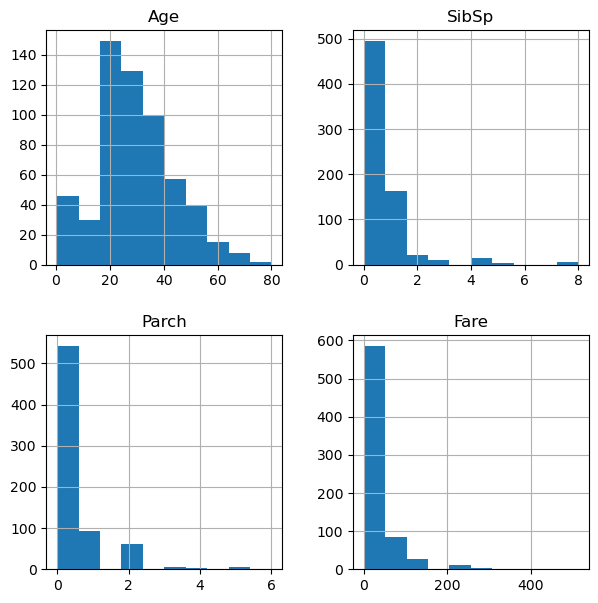

In [20]:
num_columns = ['Age', 'SibSp', 'Parch', 'Fare']

X_train[num_columns].hist(figsize=(7,7))
plt.show()

Распределение пассажиров по возрастам  близко к нормальному, остальные по форме далеки от нормального распределения. Также признаки имеют очень разные масштабы.

Проверим наличие корреляции между количественными признакми.

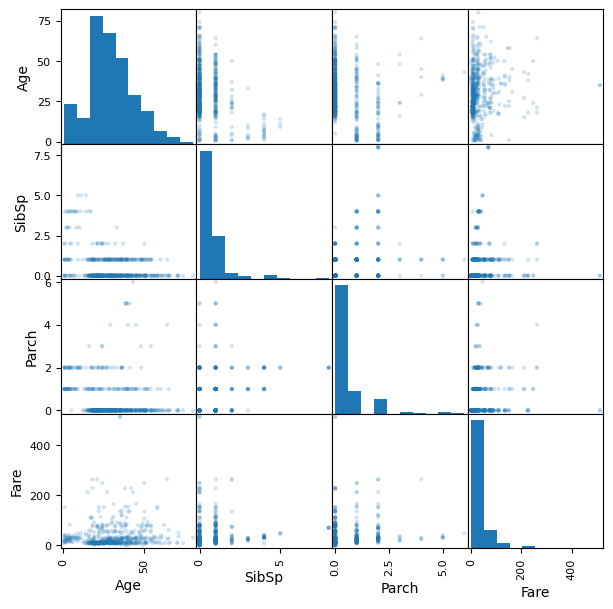

In [21]:
scatter_matrix(X_train[num_columns],
               figsize=(7, 7),
               alpha=0.2,
              )

plt.show()

Построим матрицу корреляции

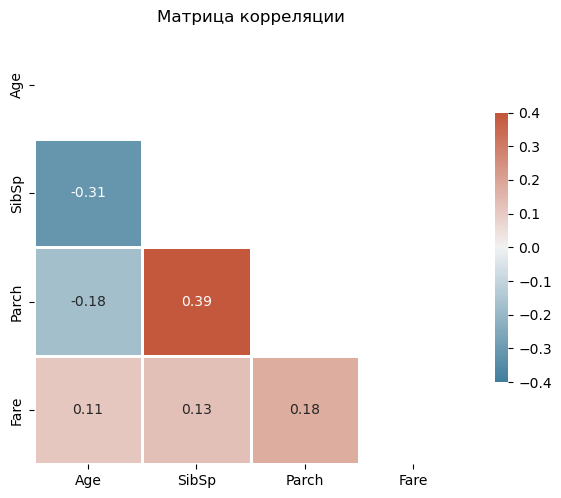

In [22]:
def plot_corr_matrix(df, size=(7, 7), vmin=-1, vmax=1, method='pearson'):
    corr = df.corr(method=method)
    
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    f, ax = plt.subplots(figsize=size)
    
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(corr,
                mask=mask,
                cmap=cmap,
                annot=True,
                vmax=vmax,
                vmin=vmin,
                center=0.0,
                square=True,
                linewidths=1.0,
                cbar_kws={'shrink': 0.5},
                ax=ax
               )
    
    ax.set_title('Матрица корреляции')
    
    plt.show()
    
plot_corr_matrix(X_train[num_columns], vmin=-0.4, vmax=0.4)

Наблюдается небольшая отрицательная корреляция между признакми `SibSp` и `Age`, коэффициент корреляции равер -0.31, и небольшая положительная корреляция между `Parch` и `SibSp`, коэффициент корреляции равен 0.39.

### Детальный анализ признаков
Рассмотрим каждый признак по отдельности, чтобы найти перспективные преобразования для них и выявить аномалии в данных. Признаки `PassengerId` и `Ticket` рассматривать не будем.

Для этого снова присоединим к набору целевой признак и присвоем их переменной `exploratory_set`.

In [23]:
exploratory_set = pd.concat([X_train, y_train], axis='columns')
exploratory_set.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
692,693,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S,1
481,482,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S,0
527,528,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S,0
855,856,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S,1
801,802,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.0,1,1,C.A. 31921,26.2500,NaN,S,1


#### Pclass
Посчитаем количество пассажиров для каждого класса билета.

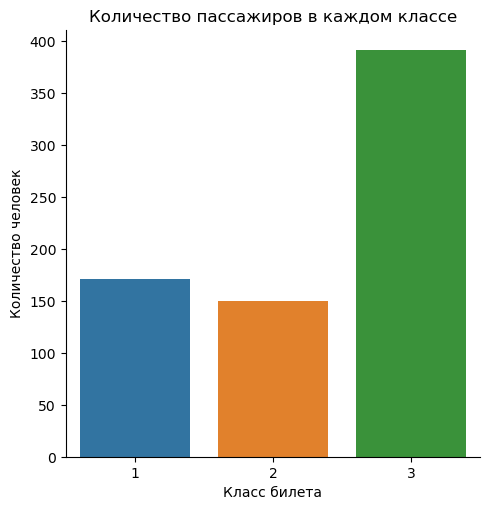

3    391
1    171
2    150
Name: Pclass, dtype: int64

In [24]:
sns.catplot(data=exploratory_set, x='Pclass', kind='count')

plt.title('Количество пассажиров в каждом классе')
plt.xlabel('Класс билета')
plt.ylabel('Количество человек')

plt.show()

display(exploratory_set.Pclass.value_counts())

Больше всего пассажиров находились в третьем классе.

Оценим долю выживших для каждого класса.

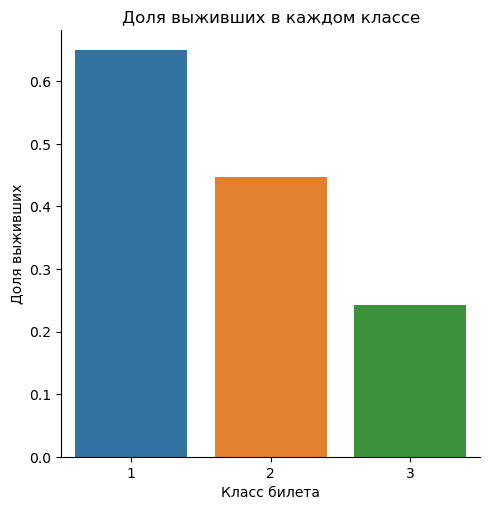

In [25]:
sns.catplot(data=exploratory_set, x='Pclass', y='Survived', kind='bar', errorbar=None)

plt.title('Доля выживших в каждом классе')
plt.xlabel('Класс билета')
plt.ylabel('Доля выживших')

plt.show()

Самая высока смертность была среди пассажиров третьего класса, возможно, это было связано с тем, что их каюты находились дальше всего от спасательных шлюпок.

Оценим долю выживших для каждого класса в разрезе полов.

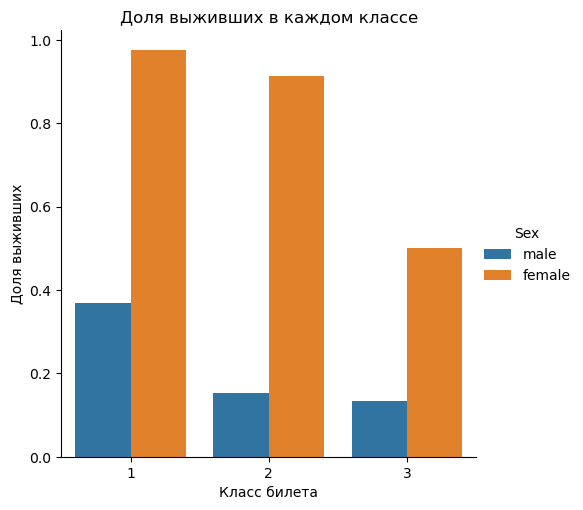

In [26]:
sns.catplot(data=exploratory_set, x='Pclass', y='Survived', hue='Sex', kind='bar', errorbar=None)

plt.title('Доля выживших в каждом классе')
plt.xlabel('Класс билета')
plt.ylabel('Доля выживших')

plt.show()

Таким образом, в каждом классе выжило больше женщин, чем мужчин. Самая высокая смертность была среди мужчин третьего класса.

#### Name
Имена пассажиров, как мы заметили в предварительном анализе, все уникальны. Однако, они содержат титул, который может указывать на социально-экономический статус пассажира и может быть связан с шансами выжить в кораблекружении.

Выведем первые 5 значений признака `Name`.

In [27]:
exploratory_set[['Name']].head()

,Name
692,"Lam, Mr. Ali"
481,"Frost, Mr. Anthony Wood ""Archie"""
527,"Farthing, Mr. John"
855,"Aks, Mrs. Sam (Leah Rosen)"
801,"Collyer, Mrs. Harvey (Charlotte Annie Tate)"


Выделим новый признак `Title` (титул) и добиви его к `exploratory_set`, затем выведем первые 5 строк получившегося датафрейма.

In [28]:
exploratory_set['Title'] = exploratory_set.Name.str.extract(pat=r'\b,\s(.+?)\.\s[\b(]?', expand=True)
exploratory_set['Title'] = exploratory_set['Title'].str.lower()
exploratory_set.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Title
692,693,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S,1,mr
481,482,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S,0,mr
527,528,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S,0,mr
855,856,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S,1,mrs
801,802,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.0,1,1,C.A. 31921,26.2500,NaN,S,1,mrs


Посчитаем описательные статистики для нового признака.

In [29]:
exploratory_set[['Title']].describe()

,Title
count,712
unique,14
top,mr
freq,412


Определим количество повторений каждого титула в наборе данных.

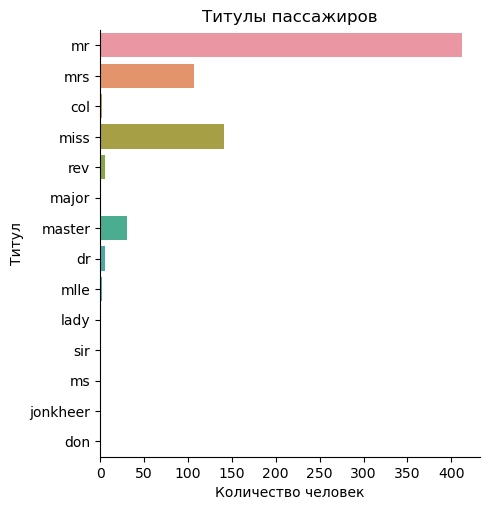

mr          412
miss        141
mrs         107
master       31
dr            6
rev           5
col           2
mlle          2
major         1
lady          1
sir           1
ms            1
jonkheer      1
don           1
Name: Title, dtype: int64

In [30]:
sns.catplot(data=exploratory_set, y='Title', kind='count')

plt.title('Титулы пассажиров')
plt.xlabel('Количество человек')
plt.ylabel('Титул')

plt.show()

display(exploratory_set.Title.value_counts(dropna=False))

Обращение *master* в то время использовалось по отношению к младенцам мужского пола. Также признак содержит несколько редко встречающихся титулов. Выведем их, затем вынесем в отдельный список `aristocratic_titles`.

In [31]:
aristocratic_titles = pd.DataFrame(exploratory_set.Title.value_counts()).query('Title < 10')
display(aristocratic_titles)

aristocratic_titles = list(aristocratic_titles.index)

,Title
dr,6
rev,5
col,2
mlle,2
major,1
lady,1
sir,1
ms,1
jonkheer,1
don,1


Заменим их значением *aristocratic* (аристократический).

In [32]:
exploratory_set.loc[exploratory_set.Title.isin(aristocratic_titles), 'Title'] = 'aristocratic'

Посмотрим как владельцы разных титулов были распределены по классам билетов.

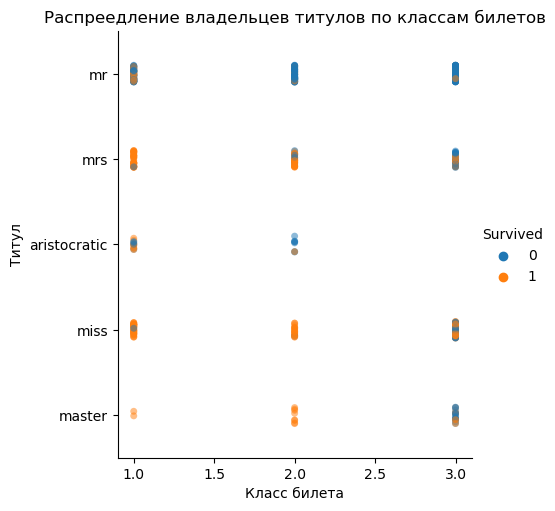

In [33]:
sns.catplot(data=exploratory_set, y='Title', x='Pclass', hue='Survived', orient='h', alpha=0.5)

plt.title('Распреедление владельцев титулов по классам билетов')
plt.xlabel('Класс билета')
plt.ylabel('Титул')

plt.show()

Владельцы аристократических титулов занимали только первый и второй класс.

Оценим долю выживших для каждого титула. Также просматривается некоторая связь между титулом, классом и долей выживших.

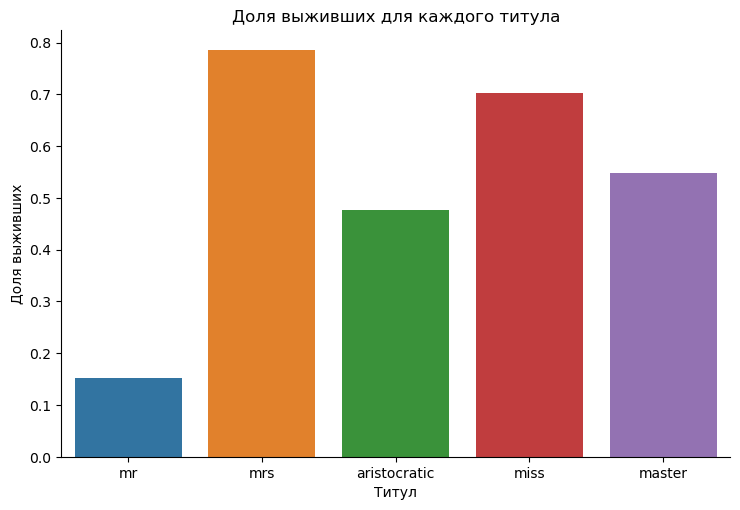

In [34]:
sns.catplot(data=exploratory_set, x='Title', y='Survived', kind='bar', errorbar=None, aspect=1.5)

plt.title('Доля выживших для каждого титула')
plt.xlabel('Титул')
plt.ylabel('Доля выживших')

plt.show()

По смотрим ту же метрику в разрезе полов.

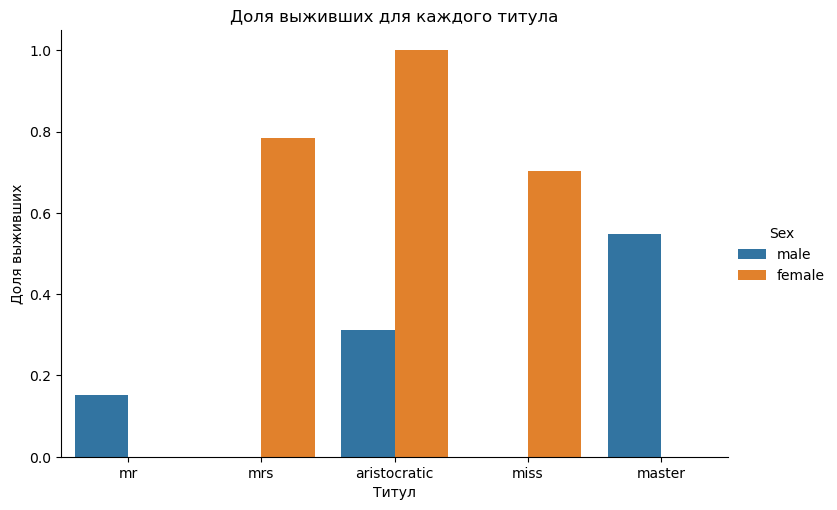

In [35]:
sns.catplot(data=exploratory_set, x='Title', y='Survived', hue='Sex', kind='bar', errorbar=None, aspect=1.5)

plt.title('Доля выживших для каждого титула')
plt.xlabel('Титул')
plt.ylabel('Доля выживших')

plt.show()

Среди мужчин на Титанике аристократы и младенцы имели более высокие шансы спастись.

#### Sex
Оценим количество женщин и мужчин севших на Титаник

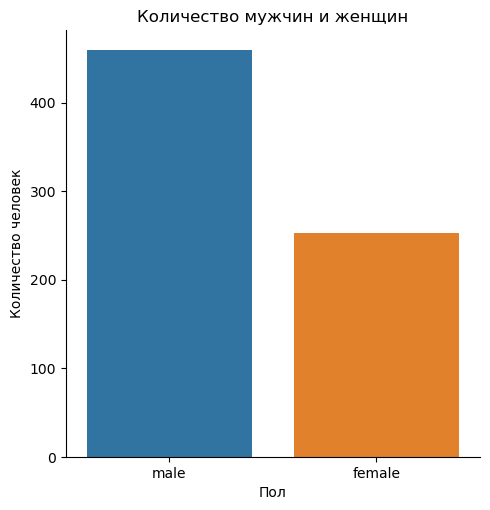

male      459
female    253
Name: Sex, dtype: int64

In [36]:
sns.catplot(data=exploratory_set, x='Sex', kind='count')

plt.title('Количество мужчин и женщин')
plt.xlabel('Пол')
plt.ylabel('Количество человек')

plt.show()

display(X_train.Sex.value_counts())

Мужчин на титанике было почти в 2 раза больше чем женщин.

Оценим количество выживших пассажиров каждого пола.

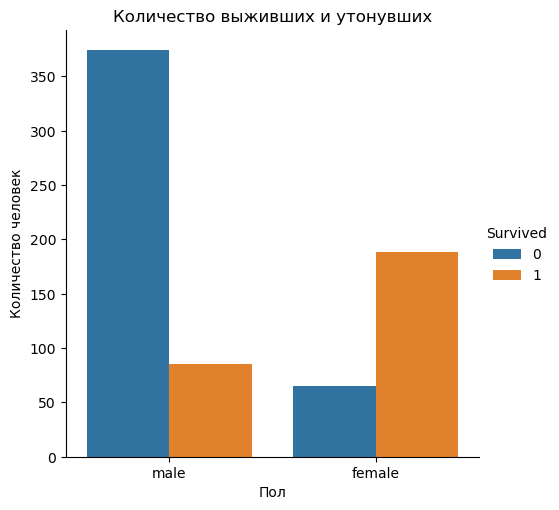

In [37]:
sns.catplot(data=exploratory_set, x='Sex', hue='Survived', kind='count')

plt.title('Количество выживших и утонувших')
plt.xlabel('Пол')
plt.ylabel('Количество человек')

plt.show()

Оценим долю выживших среди мужчин и женщин

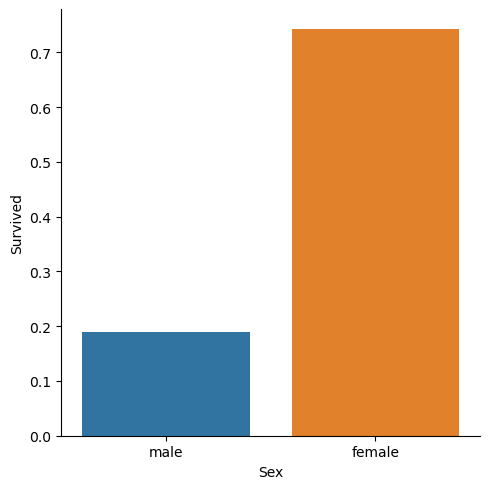

In [38]:
sns.catplot(data=data, x='Sex', y='Survived', kind='bar', errorbar=None)
plt.show()

Женщины на Титанике явно имели более высоки шансы выжить, чем мужчины, что согласуется с протоколом "Женщины и дети первые", действовавшим в то время.

#### Age

Рассмотрим распределение возрастов пассажиров Титаника, для этого построим гистограмму признака `Age`.

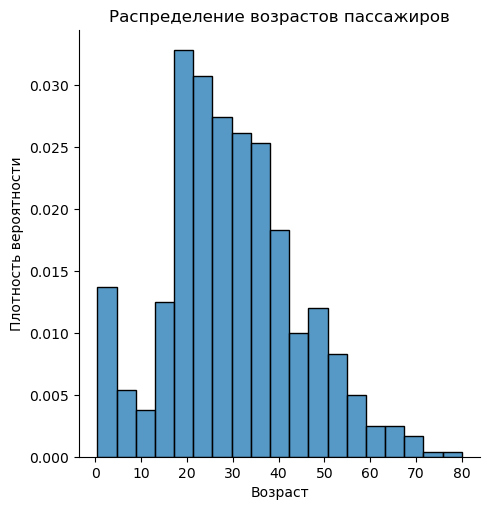

count    575.000000
mean      29.807687
std       14.485211
min        0.420000
25%       21.000000
50%       28.500000
75%       39.000000
max       80.000000
Name: Age, dtype: float64

In [39]:
sns.displot(exploratory_set.Age, stat='density')

plt.xlabel('Возраст')
plt.ylabel('Плотность вероятности')
plt.title('Распределение возрастов пассажиров')

plt.show()

display(exploratory_set.Age.describe())

Форма распределения отклоняется от формы нормального.

Проверим гипотезу о том, что выжившие пассажиры моложе погибших. Построим распределение возрастов отдельно для погибших и отдельно для выживших.

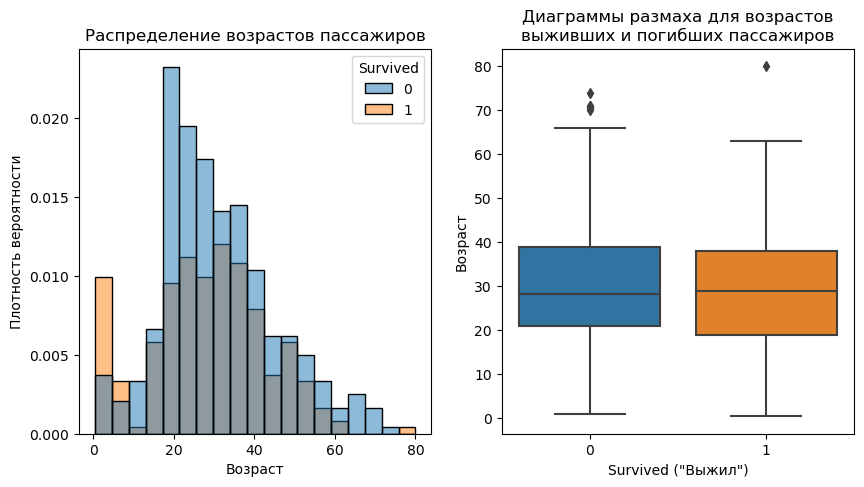

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))


sns.histplot(data=exploratory_set, x='Age', stat='density', hue='Survived', ax=ax[0])

ax[0].set_xlabel('Возраст')
ax[0].set_ylabel('Плотность вероятности')
ax[0].set_title('Распределение возрастов пассажиров')

sns.boxplot(data=exploratory_set, x='Survived', y='Age', ax=ax[1])

ax[1].set_xlabel('Survived ("Выжил")')
ax[1].set_ylabel('Возраст')
ax[1].set_title('Диаграммы размаха для возрастов\nвыживших и погибших пассажиров')

plt.show()

Гистограммы накладываются друг на друга, а на диаграммах размаха есть незначительное количество выбросов. Пока что не будем убирать выбросы, так как масимальное значение возраста пассажира равно 80 годам, что выглядит реалистично.

Выполним t-тест, чтобы окончательно разобраться была ли разница между средним возрастом выживших и средним возрастом погибших пассажиров. Выдвенем следующие нулевую (**H0**) и альтернативную (**H1**) гипотезы:
- **H0** - средний возраст в обеих группах одинаков;
- **H1** - средний возраст групп различается.

Уровень значимости **p** выберем равным **0.95**.

Прежде чем выполнить тест, расчитаем количество наблюдений в каждой группе, среднее значение и стандартное отклонение.

In [41]:
exploratory_set.groupby('Survived').Age.agg(['count', 'mean', 'std'])

,count,mean,std
Survived,,,
0,342,30.814327,14.121743
1,233,28.330129,14.910473


Выборки имеют разный размер, поэтому установим параметр `equal_var=False` при вызове метода `scipy.stats.ttest_ind()`. 

Также отметим, что средние значения выборок различаются, а стандартные отклонения очень близки, но всё же разные.

Выполним t-тест.

In [42]:
results = ttest_ind(exploratory_set.query('Survived == 0').Age.dropna(),
                    exploratory_set.query('Survived == 1').Age.dropna(),
                    equal_var=False,
                   )

print(f'p-значение: {results.pvalue:.3f}')

alpha = 0.05

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

p-значение: 0.046
Отвергаем нулевую гипотезу.


Законен вопрос мог ли получисться такой результат из-за выбросов?

Удалим выбросы, для этого в выборках оставим только пассажиров моложе 70 лет, и повторно выполним тест. После очистки данных от выбросов выведем диаграммы размаха и результат тестирования гипотезы.

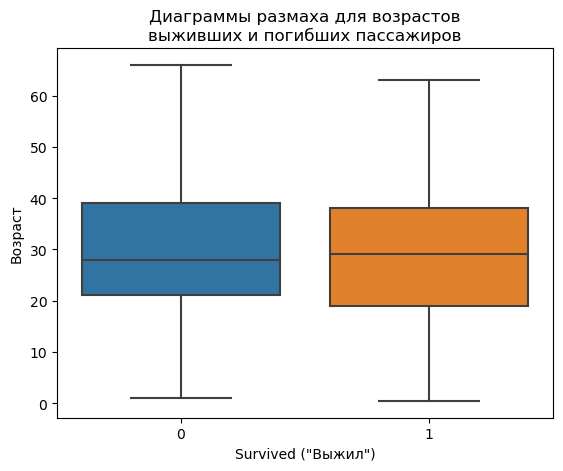

p-значение: 0.080
Не получилось отвергнуть нулевую гипотезу.


In [43]:
sns.boxplot(data=exploratory_set.query('Age < 70'), x='Survived', y='Age')

plt.xlabel('Survived ("Выжил")')
plt.ylabel('Возраст')
plt.title('Диаграммы размаха для возрастов\nвыживших и погибших пассажиров')

plt.show()


results = ttest_ind(exploratory_set.query('Survived == 0 and Age < 70').Age.dropna(),
                    exploratory_set.query('Survived == 1 and Age < 70').Age.dropna(),
                    equal_var=False,
                   )

print(f'p-значение: {results.pvalue:.3f}')

alpha = 0.05

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

Оценим к каком квантилю относится значение 70 (после удаления пропусков).

In [44]:
round(percentileofscore(exploratory_set.Age.dropna(), 70) / 100, 2)

0.99

**Можно подытожить, что у нас нет оснований утверждать, что средний возраст выживших и погибших отличается, или что фактор возраста имел решающее значение при спасении.**

Возраст непрерывная величина, но мы имеем дело с задачей классификации. Может быть целесообразным разбить всех пассажиров на на возрастные группы. В группы с более высокими номерами будем относить пассажиров, которые старше. При этом для дискретизации будем использовать функцию `pd.qcut()`, чтобы в каждой группе оказалось приблизительно одинаковое количество значений.

In [45]:
exploratory_set['AgeGroup'] = pd.qcut(exploratory_set.Age, q=7, labels=list(range(7)))

Проверим количество пассажиров в каждой возрастной групе.

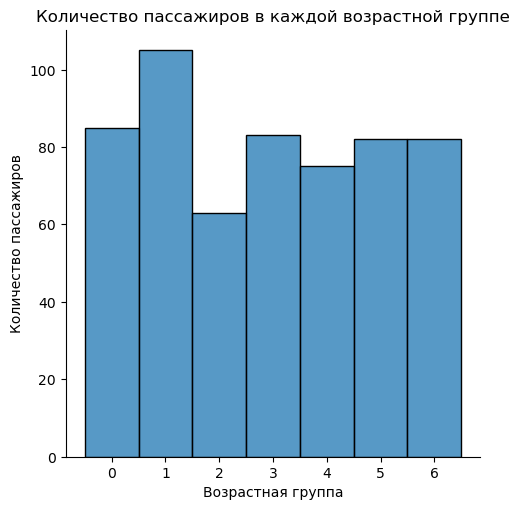

In [46]:
sns.displot(exploratory_set, x='AgeGroup', kind='hist')

plt.title('Количество пассажиров в каждой возрастной группе')
plt.xlabel('Возрастная группа')
plt.ylabel('Количество пассажиров')

plt.show()

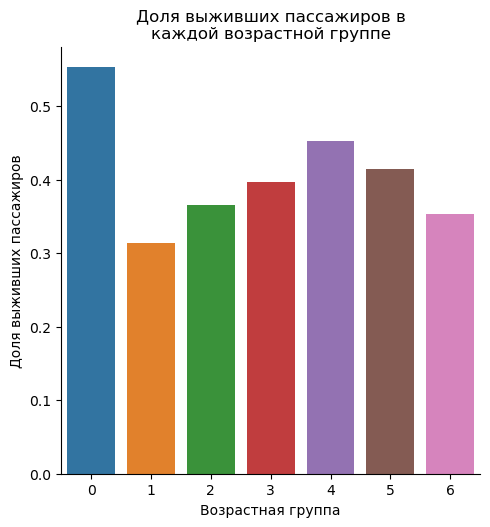

In [47]:
sns.catplot(data=exploratory_set, x='AgeGroup', y='Survived', kind='bar', errorbar=None)

plt.title('Доля выживших пассажиров в\nкаждой возрастной группе')
plt.xlabel('Возрастная группа')
plt.ylabel('Доля выживших пассажиров')

plt.show()

Разбивка пассажиров на возрастные группы позволяет предположить наличие закономерности между возрастом пассажира и шансом спастись. Попробуем посмотреть сохраняется ли эта закономерность как для мужчин так и для женщин.

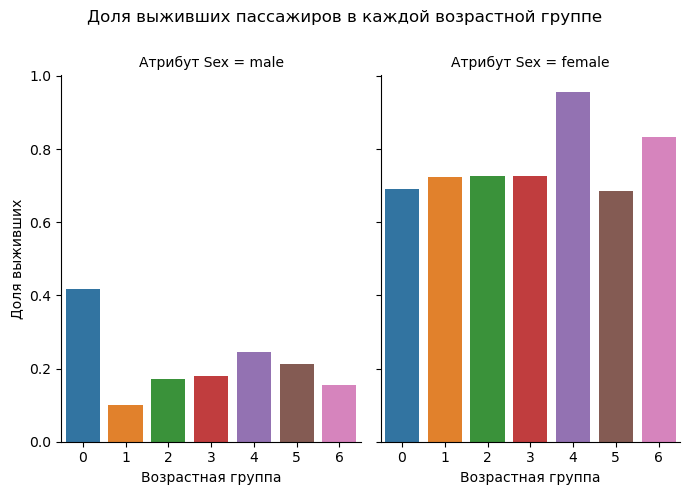

In [48]:
g = sns.catplot(data=exploratory_set, x='AgeGroup', y='Survived', col='Sex', kind='bar', errorbar=None, aspect=0.7)

g.set(xlabel='Возрастная группа', ylabel='Доля выживших')
g.set_titles(col_template="Атрибут Sex = {col_name}")
g.figure.suptitle('Доля выживших пассажиров в каждой возрастной группе')
g.figure.subplots_adjust(top=0.85)

plt.show()

Доля выживших пассажиров среди женщин выше и она практически не меняется взависимости от возрастной группы. Для мужчин просматривается связь между возрастной группой и долей выживших.

#### SibSp

Рассмотрим как распределены значения атрибута `SibSp`.

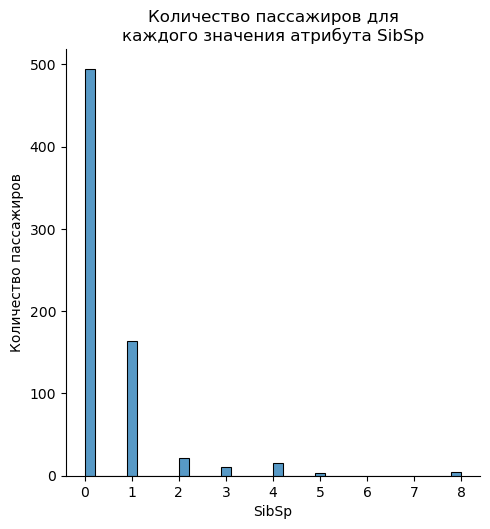

In [49]:
sns.displot(data=exploratory_set, x='SibSp', kind='hist')

plt.title('Количество пассажиров для\nкаждого значения атрибута SibSp')
plt.ylabel('Количество пассажиров')

plt.show()

Оценим долю выживших для каждого значения атрибута `SibSp`.

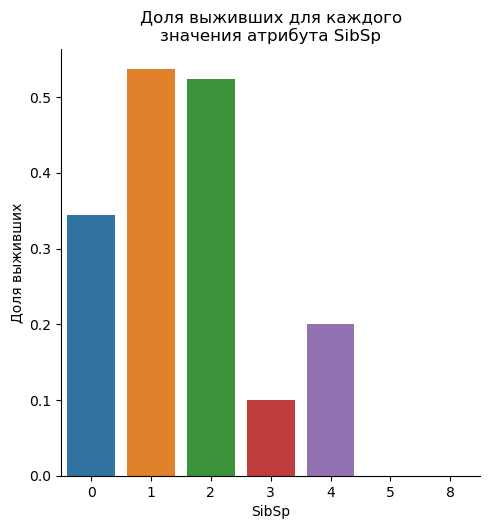

In [50]:
sns.catplot(data=exploratory_set, x='SibSp', y='Survived', kind='bar', errorbar=None)

plt.title('Доля выживших для каждого\nзначения атрибута SibSp')
plt.ylabel('Доля выживших')

plt.show()

#### Parch

Рассмотрим как распределены значения атрибута `Parch`.

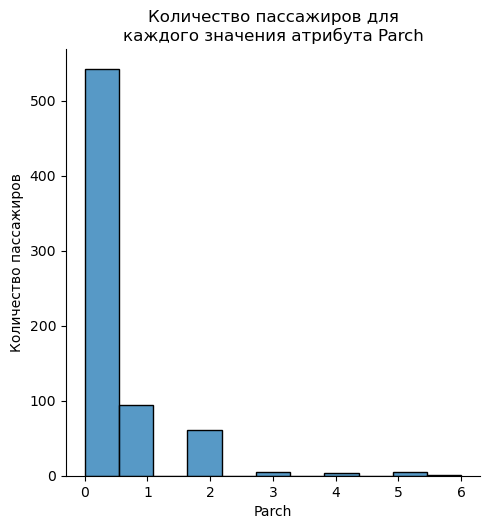

In [51]:
sns.displot(exploratory_set, x='Parch', kind='hist')

plt.title('Количество пассажиров для\nкаждого значения атрибута Parch')
plt.ylabel('Количество пассажиров')

plt.show()

Оценим долю выживших для каждого значения атрибута `Parch`.

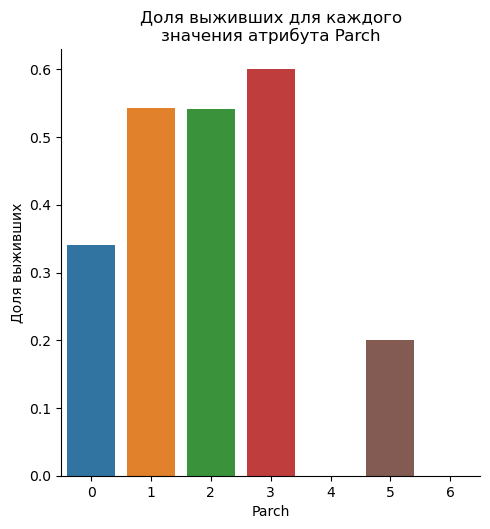

In [52]:
sns.catplot(data=exploratory_set, x='Parch', y='Survived', kind='bar', errorbar=None)

plt.title('Доля выживших для каждого\nзначения атрибута Parch')
plt.ylabel('Доля выживших')

plt.show()

Перспективной может оказаться идея добавить атрибут `Family`, я вляющийся суммой атрибутов `Parch` и `SibSp`.

In [53]:
exploratory_set['Family'] = exploratory_set.Parch + exploratory_set.SibSp

Построим гистограмму признака `Family`.

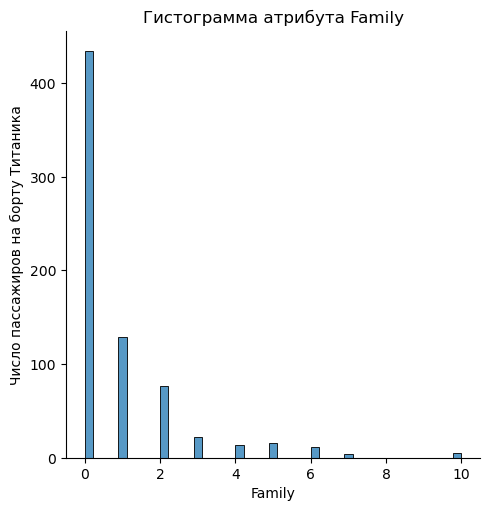

In [54]:
g = sns.displot(data=exploratory_set, x='Family', kind='hist')

plt.ylabel('Число пассажиров на борту Титаника')
plt.title('Гистограмма атрибута Family')

plt.show()

Изучим долю выживших для каждого значения атрибута `Family`

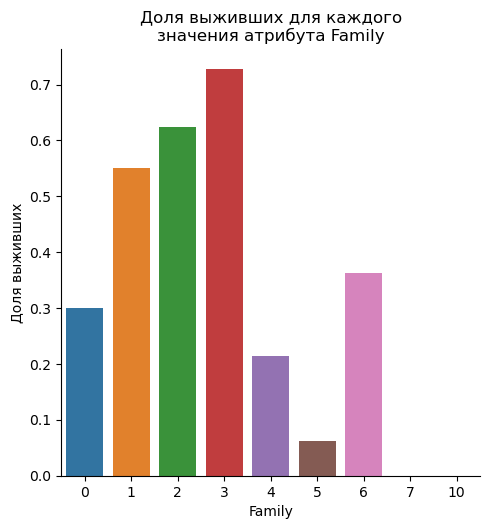

In [55]:
sns.catplot(data=exploratory_set, x='Family', y='Survived', kind='bar', errorbar=None)

plt.title('Доля выживших для каждого\nзначения атрибута Family')
plt.ylabel('Доля выживших')

plt.show()

Также можно попробовать добавить атрибут `isFamily`, который будет равен 1, если пассажир путешествовал с семьёй (если атрибут `Family` больше 0) и в противном случае равен 0.

In [56]:
exploratory_set['isFamily'] = exploratory_set.Family.clip(lower=0, upper=1)

Проверим сколько человек на Титанике путешествовали с семьёй.

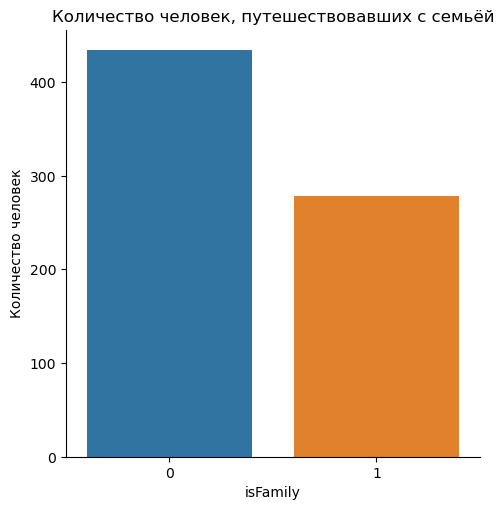

In [57]:
sns.catplot(data=exploratory_set, x='isFamily', kind='count')

plt.title('Количество человек, путешествовавших с семьёй')
plt.ylabel('Количество человек')

plt.show()

Изучим долю выживших в обеих группах.

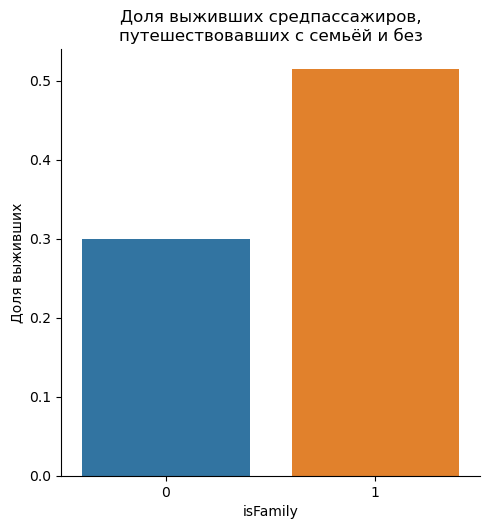

In [58]:
sns.catplot(data=exploratory_set, x='isFamily', y='Survived', kind='bar', errorbar=None)

plt.title('Доля выживших средпассажиров,\nпутешествовавших с семьёй и без')
plt.ylabel('Доля выживших')

plt.show()

#### Fare

Проверим нет ли связи между стоимостью билета и шансом выжить в кораблекрушении. 

Сначала построим гистограмму атрибута `Fare`.

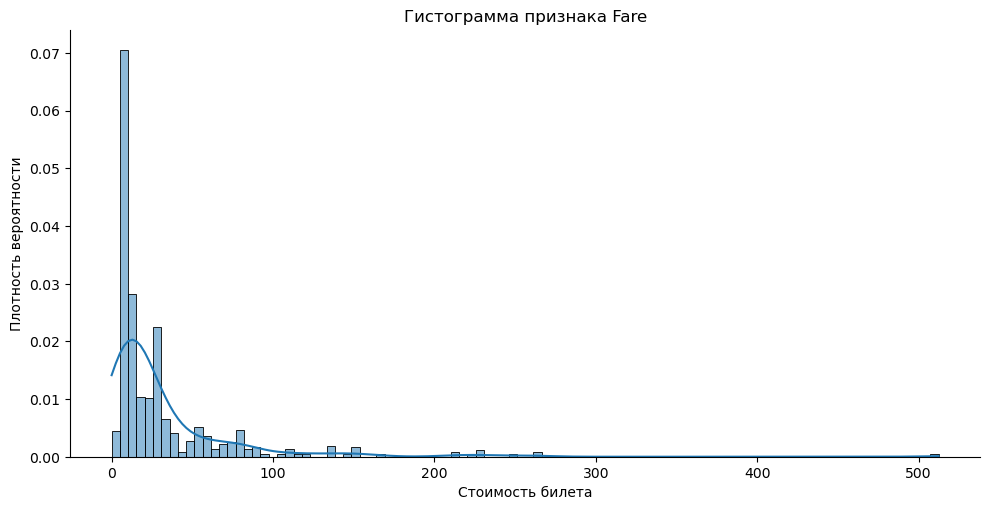

In [59]:
sns.displot(data=exploratory_set, x='Fare', stat='density', aspect=2, kde=True)

plt.title('Гистограмма признака Fare')
plt.xlabel('Стоимость билета')
plt.ylabel('Плотность вероятности')

plt.show()

Распределение имеет "очень тяжёлый хвост".

Посмотрим как распределена стоимость билетов взависимости от класса.

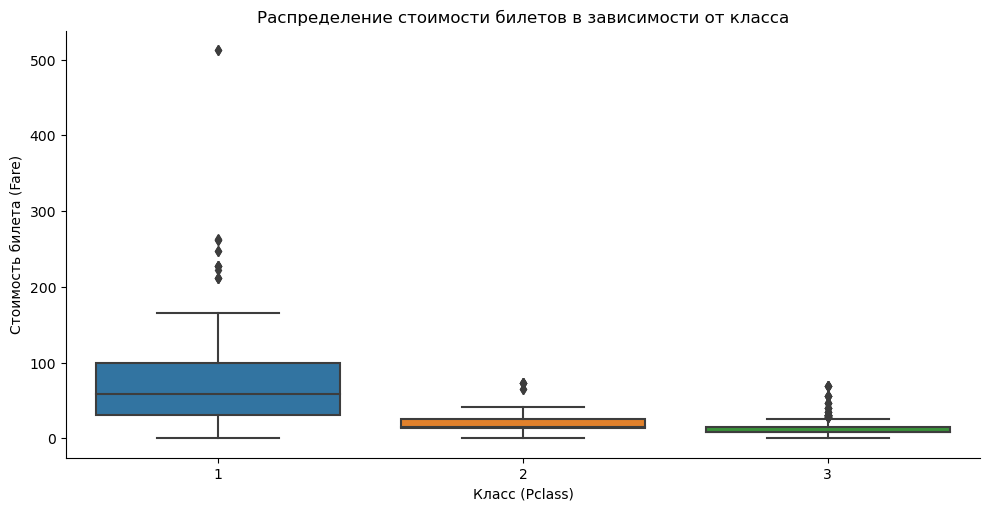

In [60]:
sns.catplot(data=exploratory_set, y='Fare', x='Pclass', aspect=2, kind='box')

plt.title('Распределение стоимости билетов в зависимости от класса')
plt.xlabel('Класс (Pclass)')
plt.ylabel('Стоимость билета (Fare)')

plt.show()

Посмотрим есть ли разница между стомостями билетов погибших и выживших для каждого класса.

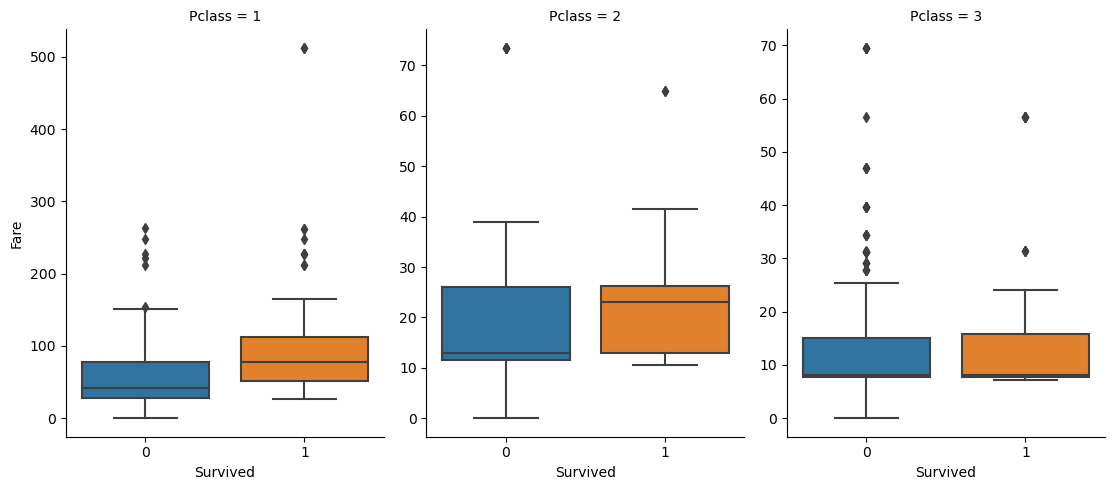

In [61]:
sns.catplot(data=exploratory_set, y='Fare', x='Survived', col='Pclass', sharey=False, kind='box', aspect=0.75)

plt.show()

Явной зависимости не просмативается.

Можно попробовать дискретизировать признак `Fare` аналогично тому как это было сделано с признакоа `Age`.

In [62]:
exploratory_set['FareGroup'] = pd.qcut(exploratory_set.Fare, 6, labels=range(6))

Оценим долю выживших в каждой группе признака `FareGroup`.

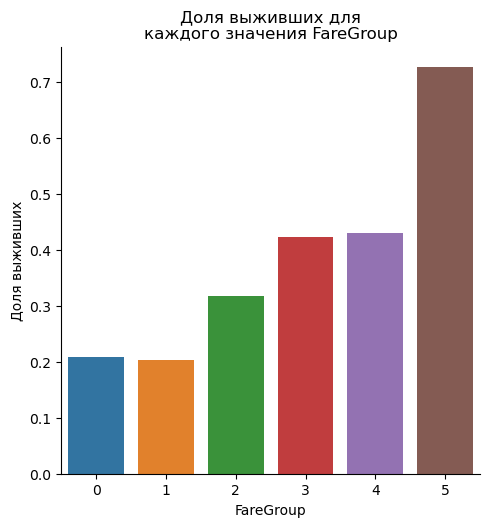

In [63]:
sns.catplot(data=exploratory_set, x='FareGroup', y='Survived', kind='bar', errorbar=None)

plt.title('Доля выживших для\nкаждого значения FareGroup')
plt.ylabel('Доля выживших')

plt.show()

#### Cabin

Как было отмечено ранее признка `Cabin` 9номер каюты) содержит слишком большое количество уникальных значений и пропусков.

In [64]:
print(f'Признак Cabin содержит {exploratory_set.Cabin.nunique()} уникальных значений.')
print(f'Признак Cabin содержит {exploratory_set.Cabin.isna().sum()} пропусков.')

Признак Cabin содержит 127 уникальных значений.
Признак Cabin содержит 552 пропусков.


Попробуем создать признак `isCabin`, который будет содержать 1, если номер каюты известен, и 0 в противном случае.

In [65]:
exploratory_set['isCabin'] = exploratory_set.Cabin.isna().astype('int')

Посмотрим различается ли доля выживших в зависимости от значения признака `isCabin`.

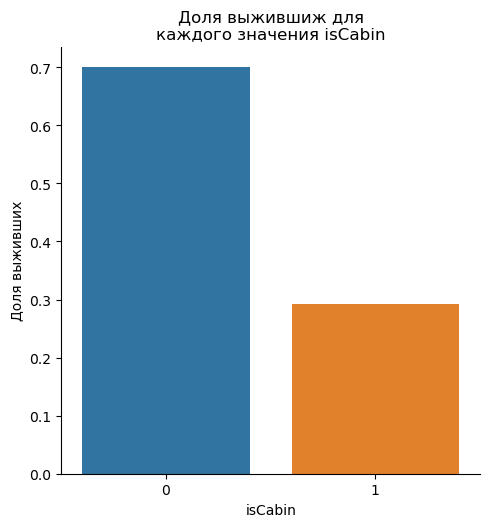

In [66]:
sns.catplot(data=exploratory_set, x='isCabin', y='Survived', kind='bar', errorbar=None)

plt.title('Доля выжившиж для\nкаждого значения isCabin')
plt.ylabel('Доля выживших')

plt.show()

Оказалось, что среди пассажиров, для которых номер каюты известен, доля выживших ниже.

#### Embarked

Посмотрим сколько пассажиров село на Титаник в каждом порту.

S    516
C    139
Q     55
Name: Embarked, dtype: int64

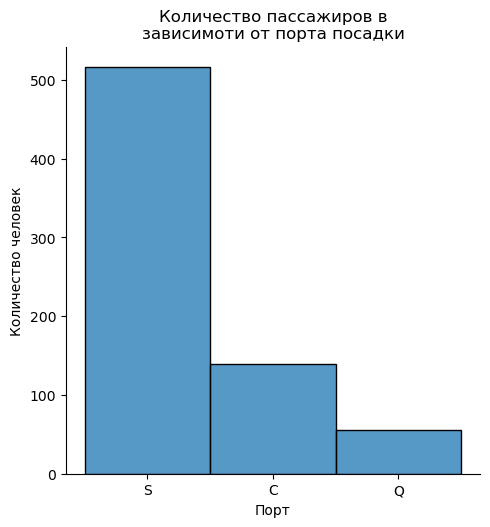

In [67]:
display(exploratory_set.Embarked.value_counts())


sns.displot(data=exploratory_set, x='Embarked', kind='hist')

plt.title('Количество пассажиров в\nзависимоти от порта посадки')
plt.xlabel('Порт')
plt.ylabel('Количество человек')

plt.show()

Больше всего человек село на корабль в Саутгемптоне.

Проверим долю выживших в зависимости от значения признака `Embarked`.

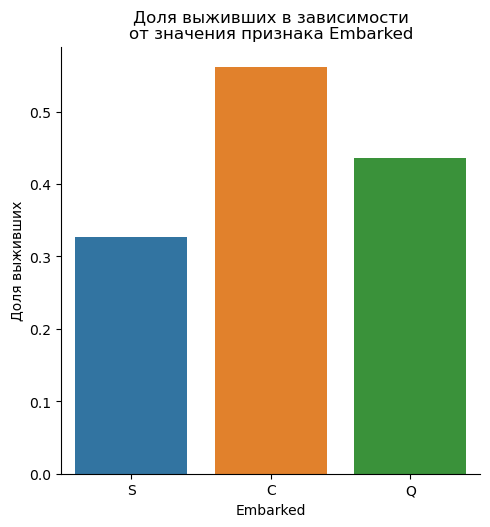

In [68]:
sns.catplot(data=exploratory_set, x='Embarked', y='Survived', kind='bar', errorbar=None)

plt.title('Доля выживших в зависимости\nот значения признака Embarked')
plt.ylabel('Доля выживших')

plt.show()

### Вывод

1. Присутствует дисбаланс классов
1. Требуется кодирование признаков с типом `object`
1. Требуется удаление неинформативных признаков
1. Требуется обработка пропусков
1. Требуется стандартизация данных
1. К исследовательскому набору были добавлены новые признаки, информативность которых еще предстоит оценить:
    - `Title`
    - `AgeGroup`
    - `Family`
    - `isFamily`
    - `FareGroup`
    - `isCabin`
1. Возможно наличие корреляции между добавленными и имевшимися признаками

Очень важными признаками являются класс билета `Pclass` и пол `Sex` пассажира. Могут оказаться полезны признаки `Title`, `AgeGroup`, `isFamily`. Возможно, окажутся информативны `FareGroup` и `isCabin`. Проверим это предположение после обработки данных.

Отметим что женщины имели более высокие шансы спастись, чем мужчины, и что в данных нет явных сведений о том, что более молодые пассажиры имели больше шансов выжить, однако, может оказаться, что некоторые возрастные группы имели больше шансов спастись.

## Обработка данных

### Разработка новых признаков
На этапе исследовательского анализа мы определили список новых признаков, которые могут оказаться информативны. Создадим собственные трансформеры для добавления этих признаков к обучающей выборке внутри пайплайна, напишем конвейер обработки данных и оценим информативность признаков на выходе этого конвейера.

Для кодирования категориальных переменных попробуем использовать целевероятностное кодирование с помощью `category_encoders.target_encoder.TargetEncoder`.

#### `Title`
Создадим трансформер, который будет добавлять признак `Title` к обучающей выборке.

In [69]:
def add_title(X, y=None):
    title = X.Name.str.extract(pat=r'\b,\s(.+?)\.\s[\b(]?')
    title = pd.Series(title[0], name='Title').str.lower()
    
    title = title.where(title.isin(['mr', 'miss', 'mrs', 'master']), 'aristocratic')
    
    return pd.concat([X, title], axis='columns')

TitleAdder = FunctionTransformer(func=add_title)

#### `AgeGroup` и `FareGroup`
Используем `KBinsDiscretizer` из `sklearn.preprocessing`, чтобы разделить непрерывный признак `Age` на несколько категорий и закодировать их с помощью целевероятностного кодирования (target encoding). Аналогично поступим с признаков `FareGroup`.

Приведём пайплайн, который выполнит эти операции. Предполагается, что приведённый ниже пайплайн - часть `ColumnTransformer` и на вход пайплайна подаются только два признака: `Age` и `FareGroup`. `Age` и `FareGroup` имеют тип `np.float64`, поэтому необходимо указать `TargetEncoder` на эти столбцы, задав атрибут `cols = [0, 1]`.

```Python
Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('discretizer', KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='quantile')),
    ('encoder', TargetEncoder(cols=[0, 1])),
])
```

#### `Family`
Создадим трансформер, который добавляет признак `Family` к обучающей выборке.

In [70]:
def add_family(X, y=None):
    family = X.Parch + X.SibSp
    family.name ='Family'

    return pd.concat([X, family], axis='columns')

FamilyAdder = FunctionTransformer(func=add_family)

#### `isFramily` и `isCabin`
Для добавления атрибута `isFramily` будем использовать `sklearn.preprocessing.Binarizer`.

Признак `Cabin` сам по себе нам не нужен, мы будем заменять его признаком `isCabin`. Будем исользовать `sklearn.impute.MissingIndicator`, чтобы заменить все пропущенные значения единицами, а остальные нулями.

### Оценка информативности признаков

#### Конвейер
Создадим конвейер, выполняющий обработку данных.

In [71]:
data_prep_target_enc = Pipeline([
    ('title_adder', TitleAdder),
    ('family_adder', FamilyAdder),
    
    ('col_selector', ColumnTransformer([
        ('drop', 'drop', ['PassengerId', 'Name', 'Ticket']),
        ('is_cabin', MissingIndicator(), ['Cabin']),
        ('is_family', Binarizer(), ['Family']),
        ('cat_features', 
         Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                   ('encoder', TargetEncoder()),
                  ]), 
         ['Pclass', 'Sex', 'Embarked', 'Title']
        ),
        ('age_fare', 
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('discretizer', KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='quantile')),
             ('encoder', TargetEncoder(cols=[0, 1])),
         ]), 
         ['Age', 'Fare']
        ),
        ('num_features', 
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('scaler', StandardScaler()),
         ]), 
         ['SibSp', 'Parch', 'Family']
        ),
    ], remainder='passthrough')
    ),        
])

Попробуем обработать с помощью разработанного конвейера обучающую выборку, преобразовать результат в датафрейм и вывести его первые 5 строк.

In [72]:
cols = [
    'isCabin', 
    'isFamily',
    'Pclass', 
    'Sex', 
    'Embarked', 
    'Title', 
    'AgeGroup', 
    'FareGroup', 
    'SibSp', 
    'Parch',
    'Family'
]

df = pd.DataFrame(data_prep_target_enc.fit_transform(X_train, y_train), columns=cols)
df.head()

,isCabin,isFamily,Pclass,Sex,Embarked,Title,AgeGroup,FareGroup,SibSp,Parch,Family
0,1.0,0.0,0.242967,0.185185,0.330116,0.152913,0.326203,0.733333,-0.465084,-0.466183,-0.556339
1,1.0,0.0,0.446667,0.185185,0.330116,0.152913,0.326203,0.205357,-0.465084,-0.466183,-0.556339
2,0.0,0.0,0.649123,0.185185,0.330116,0.152913,0.326203,0.733333,-0.465084,-0.466183,-0.556339
3,1.0,1.0,0.242967,0.743083,0.330116,0.785047,0.509259,0.324786,-0.465084,0.727782,0.073412
4,1.0,1.0,0.446667,0.743083,0.330116,0.785047,0.326203,0.427536,0.478335,0.727782,0.703162


#### Корреляция между обучающими признаками
Оценим корреляцию между признаками после обработки данных. Так как в наборе появились качественные признаки (хоть и закодированные), расчитаем коэффициент ранговой корреляции Кендалла.

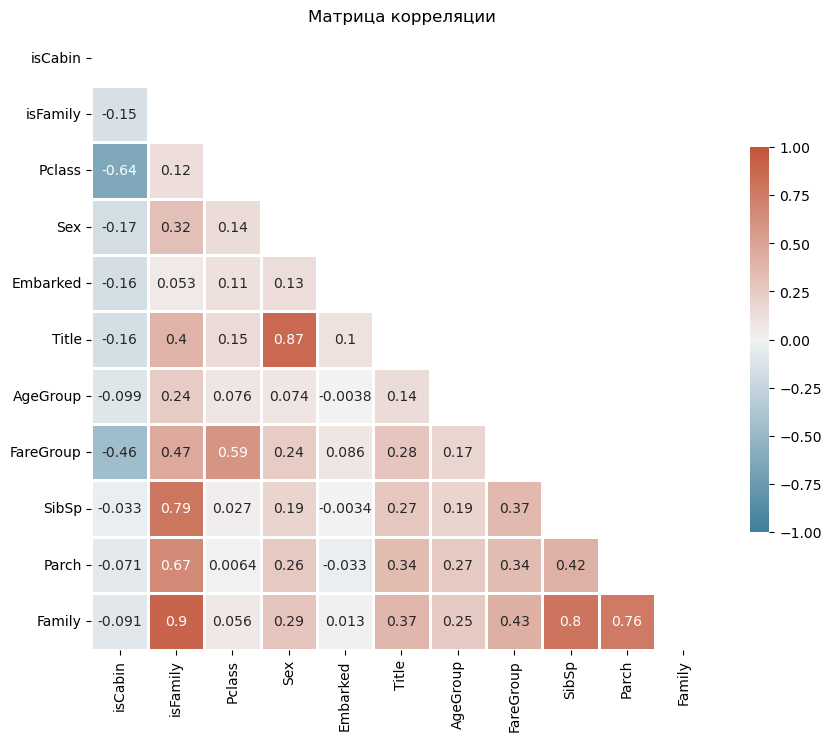

In [73]:
plot_corr_matrix(df, vmin=-1, vmax=1, size=(10, 10), method='kendall')

Мы получили скоррелированные между собой признаки. Если появление корреляции, например, между `Famlily` и `SibSp` ожидаемо, то корреляция между параметрами `Title` и `Sex` выглядит неожиданной, но объяснимой: обращения для мужчин и женщин разлины, а женщины имели более высокие шансы выжить.

В данных после обработки нашим конвейером появились признаки с сильной корреляцией, например `Title` и `Sex`, `SibSp` и `Family`. Один из признаков в каждой паре с высокой корреляцией можно отбросить, либо применить какую-либо другую технику борьбы с мультиколлинеарностью (например разложение на главные компоненты) или технику отбора признаков.

#### Взаимная информация (Mutual Information)
Чтобы выяснить какие обучающие признаки несут больше всего информации о целевом, оценим метрику Mutual Information с помощью `sklearn.feature_selection.mutual_info_classif`. Оценку будем выполнять дважды при значении параметра `n_neighbors` равном 5 и 100.

n_neighbors=5


,mutual_info
Title,0.185393
Sex,0.164156
Pclass,0.079884
isCabin,0.072192
FareGroup,0.049981
Family,0.025551
isFamily,0.018631
Embarked,0.011466
SibSp,0.004803
AgeGroup,0.000000


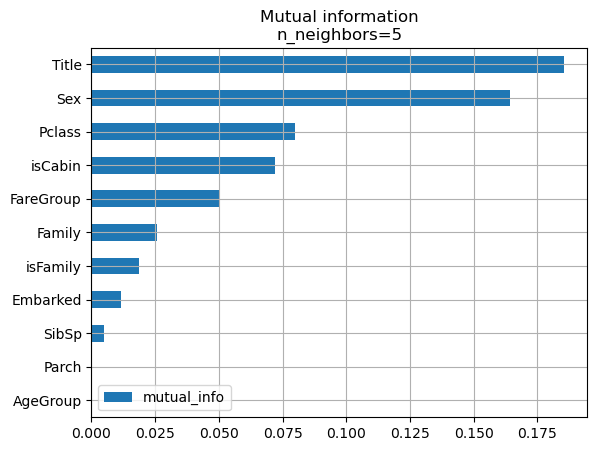

In [74]:
mi_scores = (pd
.DataFrame(mutual_info_classif(df, y_train, n_neighbors=5, random_state=SEED), 
           columns=['mutual_info'], index=df.columns)
.sort_values(by='mutual_info', ascending=False)
)

print('n_neighbors=5')
display(mi_scores)

(mi_scores
 .sort_values(by='mutual_info', ascending=True)
 .plot(kind='barh', grid=True, title='Mutual information\nn_neighbors=5')
)

plt.show()

n_neighbors=100


,mutual_info
Title,0.197552
Sex,0.188758
isCabin,0.098749
FareGroup,0.092347
Pclass,0.070996
Embarked,0.024725
isFamily,0.023218
Family,0.022750
AgeGroup,0.017652
Parch,0.013197


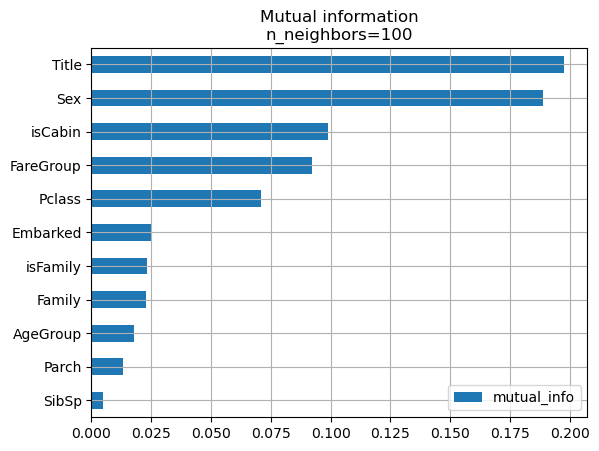

In [75]:
mi_scores = (pd
.DataFrame(mutual_info_classif(df, y_train, n_neighbors=100, random_state=SEED), 
           columns=['mutual_info'], index=df.columns)
.sort_values(by='mutual_info', ascending=False)
)

print('n_neighbors=100')
display(mi_scores)

(mi_scores
 .sort_values(by='mutual_info', ascending=True)
 .plot(kind='barh', grid=True, title='Mutual information\nn_neighbors=100')
)

plt.show()

Согласно полученным результатам, признаки неравноценны. Признаки `isFamily`, `Parch`, `SibSp`, `AgeGroup` в обоих случаях попали в 5 пирзнаков с самым низким значение метрики. Возможно, их можно будет безболезненно удалить. Среди 5 признаков с самыми высокими показателями метрики оказались `Title`, `Sex`, `isCabin`, `FareGroup` и `Pclass`.

Прежде чем удалять неинформативные признаки и часть скоррелированных, оценим базовую модель и из нескольких классификаторов выберем лучший.

## Базовая модель
В качестве базовой модели, с которой мы будем сравнивать разработанные модели, будем использовать `sklearn.dummy.DummyClassifier`

Прежде чем приступить к подбору классификатора и оценке моделей, напишем несколько функций, позволяющих быстро их оценить.

In [76]:
def print_score(estimator, features, target, score='accuracy', cv=5, n_jobs=-1):
    '''Вычисляет среднее, минимальное и максимальное значения метрики,
    полученное с помощью кросс-валидации.
    '''
    
    scores = cross_val_score(estimator,
                             X=features,
                             y=target,
                             cv=cv,
                             scoring=score,
                             n_jobs=n_jobs,
                            )
    
    return pd.DataFrame(scores, columns=[score]).agg(['mean', 'median', 'min', 'max']).transpose()


def plot_roc_curve_for_random_clf():
    '''Выводит на экран кривую ROC для классификатора, предсказывающего
       целевую переменную случайным образом.
    '''
    
    fig, ax = plt.subplots(1, 1)
    
    ax.plot([0,1], [0,1], 'k--', label='Random classifier')
    ax.grid()
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1))

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

    ax.legend(loc='lower right')

    ax.set_title('ROC curve')
    
    return fig, ax


def plot_roc_curve(y_train, y_scores, ax, style='', label=None):
    '''Печатае кривую ROC на оси ax.'''
    
    fpr, tpr, thresholds = roc_curve(y_train, y_scores)
    
    ax.plot(fpr, tpr, style, label=label)
    
    return ax


def evaluate_model(model, X, y, label, ax=None, method='predict_proba', cv=5, n_jobs=-1):
    '''Выводит на экран сводку о производительности модели, состоящую из метрик
    accuracy, f1, roc_auc и кривую ROC.
    '''
    
    df = pd.DataFrame(columns= ['mean', 'median', 'min', 'max'])
    
    for metric in ['accuracy', 'f1', 'roc_auc']:
        df = pd.concat([df, print_score(model, X, y, score=metric, cv=cv, n_jobs=n_jobs)])
        
    print(f'Значения метрик для {label}')
    
    display(df)
        
    y_scores = cross_val_predict(model, X, y, cv=cv, method=method, n_jobs=n_jobs)
    if method == 'predict_proba':
        y_scores = y_scores[:, -1]
    
    if ax is None:
        fig, ax = plot_roc_curve_for_random_clf()        
        ax = plot_roc_curve(y_train, y_scores, label=label, ax=ax)
        plt.show()
    
    else:
        ax = plot_roc_curve(y_train, y_scores, label=label, ax=ax)
        
        return ax

Значения метрик для DummyClassifier


,mean,median,min,max
accuracy,0.551975,0.566434,0.457746,0.605634
f1,0.392479,0.410714,0.297030,0.454545
roc_auc,0.512223,0.517045,0.463427,0.570286


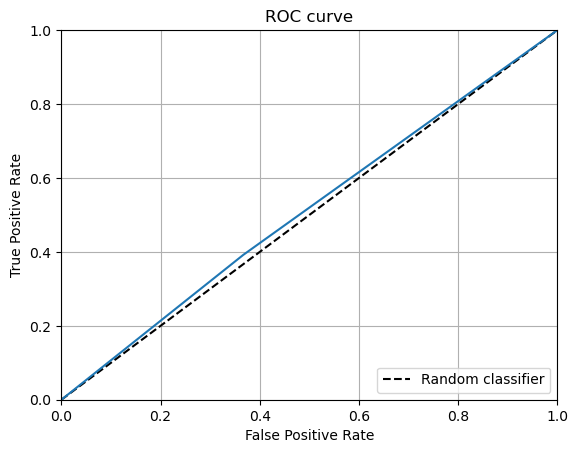

In [77]:
dummy_clf = DummyClassifier(strategy='stratified')

evaluate_model(model=dummy_clf, X=X_train, y=y_train, label='DummyClassifier')

## Выбор модели

Напишем конвейер для которого мы будем подбирать классификатор. Добавим в конвейер апсемплинг, чтобы устранить дисбаланс классов. Шаг, предназначенный для классификатора оставим пустым, так как классификатор еще предстоит подобрать.

In [78]:
pipe = Pipeline([
    ('title_adder', TitleAdder),
    ('family_adder', FamilyAdder),
    
    ('col_selector', ColumnTransformer([
        ('drop', 'drop', ['PassengerId', 'Name', 'Ticket']),
        ('is_cabin', MissingIndicator(), ['Cabin']),
        ('is_family', Binarizer(), ['Family']),
        ('cat_features', 
         Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                   ('encoder', TargetEncoder()),
                  ]), 
         ['Pclass', 'Sex', 'Embarked', 'Title']
        ),
        ('age_fare', 
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('discretizer', KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='quantile')),
             ('encoder', TargetEncoder(cols=[0, 1])),
         ]), 
         ['Age', 'Fare']
        ),
        ('num_features', 
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('scaler', StandardScaler()),
         ]), 
         ['SibSp', 'Parch', 'Family']
        ),
    ], remainder='passthrough')
    ),   

    ('smote', SMOTE()),
    
    ('feature_selection', 'passthrough'),
    
    ('classifier', 'passthrough')
])

pipe

Pipeline(steps=[('title_adder',
                 FunctionTransformer(func=<function add_title at 0x0000022DE6E61A20>)),
                ('family_adder',
                 FunctionTransformer(func=<function add_family at 0x0000022DE7E01E10>)),
                ('col_selector',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['PassengerId', 'Name',
                                                   'Ticket']),
                                                 ('is_cabin',
                                                  MissingIndicator(),
                                                  ['Cabin']),
                                                 ('is_f...
                                                                   SimpleImputer(strategy='median')),
                                                                  ('discretizer',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=6)),
                                                                  ('encoder',
                                                                   TargetEncoder(cols=[0,
                                                                                       1]))]),
                                                  ['Age', 'Fare']),
                                                 ('num_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SibSp', 'Parch',
                                                   'Family'])])),
                ('smote', SMOTE()), ('feature_selection', 'passthrough'),
                ('classifier', 'passthrough')])

Попробуем добавлять к конвейеру разные классификаторы и сравним результаты. Рассмотрим следующие классификаторы с параметрами по умолчанию:
- LogisticRegression;
- SVC;
- KNeighborsClassifier;
- DecisionTreeClassifier;
- RandomFrorestClassifier;
- GradientBoostingClassifier.

1. LogisticRegression
Значения метрик для LogisticRegression


,mean,median,min,max
accuracy,0.779538,0.776115,0.732394,0.816901
f1,0.732841,0.762644,0.653846,0.779661
roc_auc,0.854821,0.864689,0.767451,0.890365



2. SVC
Значения метрик для SVC


,mean,median,min,max
accuracy,0.797750,0.788732,0.746479,0.847222
f1,0.753988,0.763333,0.651163,0.827586
roc_auc,0.848718,0.852062,0.805601,0.872924



3. KNeighborsClassifier
Значения метрик для KNeighborsClassifier


,mean,median,min,max
accuracy,0.792175,0.783157,0.732394,0.873239
f1,0.734790,0.715633,0.678571,0.840000
roc_auc,0.819270,0.816077,0.750421,0.905724



4. DecisionTreeClassifier
Значения метрик для DecisionTreeClassifier


,mean,median,min,max
accuracy,0.794973,0.809859,0.718310,0.915493
f1,0.703696,0.730300,0.476190,0.830189
roc_auc,0.755165,0.758758,0.598485,0.873737



5. RandomForestClassifier
Значения метрик для RandomForestClassifier


,mean,median,min,max
accuracy,0.806221,0.795775,0.704225,0.887324
f1,0.732423,0.762380,0.600000,0.840000
roc_auc,0.851867,0.857977,0.744108,0.921927



6. GradientBoostingClassifier
Значения метрик для GradientBoostingClassifier


,mean,median,min,max
accuracy,0.817508,0.818271,0.760563,0.873239
f1,0.759539,0.767783,0.678571,0.846154
roc_auc,0.861584,0.871633,0.784497,0.905724


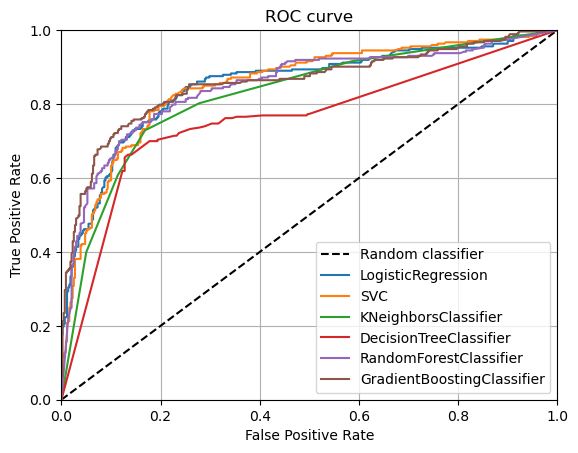

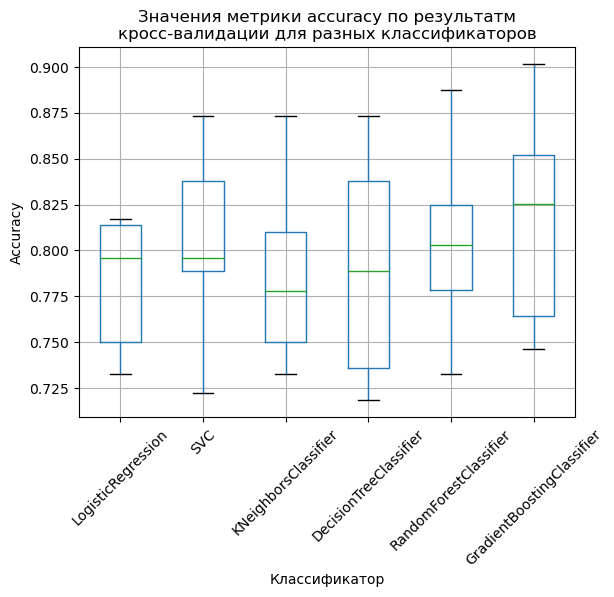

In [79]:
classifiers = [
    LogisticRegression(),
    SVC(kernel='rbf'),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
]

methods = [
    'predict_proba',
    'decision_function',
    'predict_proba',
    'predict_proba',
    'predict_proba',
    'predict_proba',
]


fig, ax = plot_roc_curve_for_random_clf()

scores_dict = dict()

for i, (classifier, method) in enumerate(zip(classifiers, methods)):
    label = type(classifier).__name__
    print(f'{i+1}. {label}')

    pipe.set_params(classifier=classifier)
    
    ax = evaluate_model(model=pipe, X=X_train, y=y_train, method=method, label=label, cv=10, ax=ax)
    
    scores_dict[label] = cross_val_score(estimator=pipe, 
                                         X=X_train, 
                                         y=y_train, 
                                         scoring='accuracy',
                                         cv=10,
                                         n_jobs=-1,
                                        )
    
    print()
    
plt.legend()
plt.show()

print()

pd.DataFrame(scores_dict).boxplot(rot=45)
plt.xlabel('Классификатор')
plt.ylabel('Accuracy')
plt.title('Значения метрики accuracy по результатм\nкросс-валидации для разных классификаторов')
plt.show()

Все модели кроме `DecisionTreeClassifier` показали достаточно хорошие результаты. `SVC(kernel='rbf')`, `RandomForestClassifier` и `GradientBoostingClassifier` показали близкие результаты, при этом значение метрик *accuracy* превысило целевое.

Проведём еще один раунд отбора лучшего классификатора среди `SVC(kernel='rbf')`, `RandomForestClassifier` и `GradientBoostingClassifier`. При этом попробуем для каждого настраивать гиперпараметры.

1. SVC
Fitting 10 folds for each of 40 candidates, totalling 400 fits
Лучшие параметры:
{'classifier__C': 0.2, 'classifier__kernel': 'rbf'}
Значения метрик для SVC


,mean,median,min,max
accuracy,0.816080,0.809859,0.763889,0.859155
f1,0.752843,0.758333,0.681818,0.800000
roc_auc,0.849954,0.853672,0.787744,0.912037



2. RandomForestClassifier
Fitting 10 folds for each of 48 candidates, totalling 480 fits
Лучшие параметры:
{'classifier__min_samples_split': 50, 'classifier__n_estimators': 200}
Значения метрик для RandomForestClassifier


,mean,median,min,max
accuracy,0.810426,0.802817,0.750000,0.859155
f1,0.763494,0.781746,0.666667,0.842105
roc_auc,0.869743,0.881118,0.803030,0.905724



3. GradientBoostingClassifier
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Лучшие параметры:
{'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 150}
Значения метрик для GradientBoostingClassifier


,mean,median,min,max
accuracy,0.831514,0.839202,0.774648,0.901408
f1,0.755469,0.763228,0.622222,0.846154
roc_auc,0.855132,0.861186,0.780438,0.909091


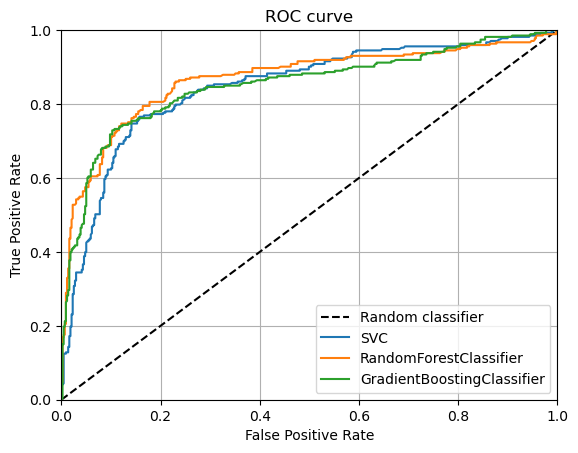

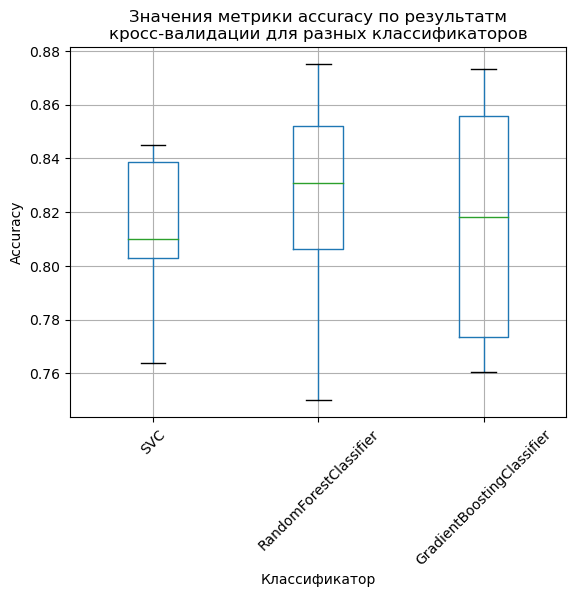

In [80]:
from sklearn.model_selection import GridSearchCV

classifiers = [
    SVC(kernel='rbf'),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
]

methods = [
    'decision_function',
    'predict_proba',
    'predict_proba',
]

params_dicts = [
    {'classifier__C': np.linspace(0.1, 2, 20),
     'classifier__kernel': ['rbf', 'sigmoid']
    },
    
    {'classifier__n_estimators': [10, 25, 50, 100, 150, 200, 250, 300],
     'classifier__min_samples_split': [2, 5, 10, 50, 100, 200],
    },
    
    {'classifier__learning_rate': [0.01, 0.025, 0.05, 0.1, 0.2],
     'classifier__n_estimators': [50, 75, 100, 150, 200],
     'classifier__min_samples_split': [2, 5, 7, 10],
     'classifier__max_depth': [2, 3, 4, 5, 7]
    },
]


scores_dict = dict()

fig, ax = plot_roc_curve_for_random_clf()

for i, (classifier, method, params) in enumerate(zip(classifiers, methods, params_dicts)):
    label = type(classifier).__name__
    print(f'{i+1}. {label}')

    pipe.set_params(classifier=classifier)
    
    
    grid_search = GridSearchCV(estimator=pipe,
                              param_grid=params,
                              cv=10,
                              scoring='accuracy',#'roc_auc',
                              n_jobs=-1,
                              verbose=1
                             )
    
    grid_search.fit(X=X_train, y=y_train)
    
    print('Лучшие параметры:')    
    print(grid_search.best_params_)
    
    scores_dict[label] = cross_val_score(estimator=grid_search.best_estimator_, 
                                         X=X_train, 
                                         y=y_train, 
                                         scoring='accuracy',
                                         cv=10,
                                         n_jobs=-1,
                                        )
    
    ax = evaluate_model(model=grid_search.best_estimator_, X=X_train, y=y_train, method=method, label=label, cv=10, ax=ax)
    
    print()
    
plt.legend()
plt.show()

print()

pd.DataFrame(scores_dict).boxplot(rot=45)
plt.xlabel('Классификатор')
plt.ylabel('Accuracy')
plt.title('Значения метрики accuracy по результатм\nкросс-валидации для разных классификаторов')
plt.show()

```Python
pipe.set_params(classifier='passthrough')
pipe.fit_transform(X_train, y_train).shape
>> (878, 11)
```

#### Отбор признаков

Попробуем выбрать информативные признаки с помощью техники называемой *Recursive feature elimination with cross-validation*. Для определения информативности функций будем использовать логистическую регрессию. Так как у нас имеется дисбаланс классов, установим параметр `class_weight='balanced'`; также установим параметры `penalty='l1'` и `solver='liblinear'`, будем надеяться, что логистическая регрессия, настроенная таким образом будет не только устойчива к выбросам, но и позволит убрать признаки имеющие пары с высокой корреляцией.

Определим оптимальное число признаков. В качестве целевой метрики выберем ROC AUC.

```Python
rfecv = RFECV(
    estimator = GradientBoostingClassifier(),#LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear'),
    step=1,
    cv=10,
    scoring='roc_auc',
    min_features_to_select=1,
    n_jobs=-1,
)

rfecv.fit(df, y_train)

print(f"Оптимальное количество признаков: {rfecv.n_features_} из {rfecv.n_features_in_}")
```

Построим график зависимости среднего значения целевой метрики от количества выбранных признаков, нанесём на график доверительный интервал для каждого значения.

```Python
n_scores = len(rfecv.cv_results_["mean_test_score"])

plt.errorbar(
    x=np.arange(n_scores) + 1,
    y=rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
    fmt='s',
    capsize=5,
    ecolor='k',
    elinewidth=1,
)

plt.xlabel("Количество признаков")
plt.ylabel("Средниее значение метрики ROC AUC")
plt.title("Зависимость метрики ROC AUC от\nколичества признаков, выбранных RFE")
plt.xlim((0, 12))
plt.ylim((0.7, 0.95))

plt.grid()

plt.show()
```

Выведем датафрейм с результатом работы алгоритма отбора признаков. Если `Support=False`, значит признак отбрасывается.

features_info = pd.DataFrame({
    'Name': rfecv.feature_names_in_,
    'Rank': rfecv.ranking_,
    'Support': rfecv.support_
}).sort_values('Rank', ignore_index=True)

features_info

В результате были отброшены признаки `AgeGroup` и `Parch`, которые имели низкое значение метрики взаимная информация, также были отброшены признаки `Sex` и `Pclass`, которые имели более высокие значения данной метрики, при этом они показывали корреляцию с признаками `Title` и `FareGroup` соответственно.

Перепишем конвейер, чтобы сразуже удалять признаки `AgeGroup`, `Parch`, `Sex`, `Pclass`.

```Python
pipe = Pipeline([
    ('title_adder', TitleAdder),
    ('family_adder', FamilyAdder),
    ('col_transformer', ColumnTransformer([
        ('drop', 'drop', ['PassengerId', 'Name', 'Ticket', 'Age', 'Embarked', 'SibSp', 'Sex', 'Parch',]),
        ('is_cabin', MissingIndicator(), ['Cabin']),
        ('fare', 
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('discretizer', KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='quantile')),
         ]), 
         ['Fare']
        ),
    ], remainder='passthrough'), 
    ),
    ('encoder', TargetEncoder(cols=list(range(5)))),
    
    ('smote', SMOTE()),
    
    ('pca', PCA()),
    
    ('classifier', 'passthrough')
])

pipe
```

```Python
data_prep_target_enc = Pipeline([
    ('title_adder', TitleAdder),
    ('family_adder', FamilyAdder),
    
    ('col_selector', ColumnTransformer([
        ('drop', 'drop', ['PassengerId', 'Name', 'Ticket', 'Age', 'Parch', 'Sex', 'Pclass']),
        ('is_cabin', MissingIndicator(), ['Cabin']),
        ('is_family', Binarizer(), ['Family']),
        ('cat_features', 
         Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                   ('encoder', TargetEncoder()),
                  ]), 
         ['Embarked', 'Title']
        ),
        ('fare', 
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('discretizer', KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='quantile')),
             ('encoder', TargetEncoder(cols=[0])),
         ]), 
         ['Fare']
        ),
        ('num_features', 
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('scaler', StandardScaler()),
         ]), 
         ['SibSp', 'Family']
        ),
    ], remainder='passthrough')
    ),        
])
```

В обучающей выборке после предобработки останутся скоррелированные признаки, имеющие низкое значение метрики mutual information. Возможно, от них можно было бы избавиться изменяя количество регуляризации в логистической регресси. Однако, так как для нас не важна интерпретируемость модели, попробуем далее избавиться от лишних признаков с помощью разложения на гравные компоненты. 